## Notes

- Default state is that effects data is uploaded from CSV in folder, and not calculated when the notebook is run.
    - This can be changes by 'uncommenting' cells 3.6.1 and 4.1, this code can take upwards of 20 min to run for each
    

- Default state is the nRMSEs for graphs are uploaded from Bootstapping files
    - This can be changed indidually for each graph within the cell by uncommenting lines for calculating RMSE and adding that value instead of the bootstrapped value
    
    
- All imports are standard libraries except for 'statannot' (adds comaprisons and p values to some graphs) which may need to be installed separately before use. 

# Import libraries 

In [1]:
%pylab inline
import scipy as sp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as mcolors
import pylab as pl

from matplotlib.colors import LogNorm, Normalize
from mpl_toolkits import mplot3d
from sklearn.metrics import mean_squared_error
from statannot import add_stat_annotation

import warnings
import itertools


Populating the interactive namespace from numpy and matplotlib


# Isolate profiling
## Import and organize single read data
- each plate is a different growth condition

In [2]:
#Create Dataframes
#Data was stored in three different files as to not overload Gen5 program
#Each plate is saved in its own sheet 

plates_dict={}
data_folder=("Data/Isolate_profiling/")
for i in range(1,31):
    dataset= (pd.read_excel(data_folder+"/Plate01to30.xlsx",
                            skiprows=range(0, 23), 
                            sheet_name="Plate "+str(i)+" - Sheet1")
              .drop(columns=["Unnamed: 0"])
              .rename(columns={600:"Plate_"+str(i)}))
    
    plates_dict[i]=dataset

for i in range(1,31):
    dataset= (pd.read_excel(data_folder+"/Plate31to60.xlsx",
                            skiprows=range(0, 23), 
                            sheet_name="Plate "+str(i)+" - Sheet1")
              .drop(columns=["Unnamed: 0"])
              .rename(columns={600:"Plate_"+str(i+30)}))
    
    plates_dict[i+30]=dataset
    
for i in range(1,37):
    dataset= (pd.read_excel(data_folder+"/Plate61to96.xlsx",
                            skiprows=range(0, 23), 
                            sheet_name="Plate "+str(i)+" - Sheet1")
              .drop(columns=["Unnamed: 0"])
              .rename(columns={600:"Plate_"+str(i+60)}))
    
    plates_dict[i+60]=dataset

In [3]:
#Create lists of carbon source and antibiotic plates
#Ordered to the numbers in plates_dict
carbon_plates=[]
for i in ["Glucose","Ribose","Xylose","Fructose",
          "Galactose","Sucrose","Cellobiose","Lactose",
          "Maltose","Citrate","Succinate","Acetate",
          "Pyruvate","Glycerol","Mannitol","Sorbitol",
          "Serine","Alanine","Proline","Lysine","MilliQ"]:
    carbon_plates.append(i+'_A')
    carbon_plates.append(i+'_B')
    carbon_plates.append(i+'_C')
    
    
abx_plates=[]
for i in ["Kanamycin","Spectinomycin","Amoxicillin",
          "Gentamicin","Streptomycin","Trimethoprim","Carbenicillin",
          "Vancomycin","Rifampicin","Chloramphenicol","Ampicillin"]:
    abx_plates.append(i+'_A')
    abx_plates.append(i+'_B')
    abx_plates.append(i+'_C')
    
#Generate dataframes with all plate info, properly titled    
carbons=pd.DataFrame(plates_dict[1]["Well"])

#Call each plate from import dictionary  
for i in range(1,64):
    carbons=carbons.merge(plates_dict[i], on="Well")
carbons=carbons.set_index("Well")
#Rename from list
carbons=carbons.rename(columns=dict(zip(list(carbons), carbon_plates)))

#Same for abx plates
abx=pd.DataFrame(plates_dict[1]["Well"])
for i in range(64,97):
    abx=abx.merge(plates_dict[i], on="Well")
abx=abx.set_index("Well")
abx=abx.rename(columns=dict(zip(list(abx), abx_plates)))

## Normalize to Blanks

In [4]:
#copy df
n_carbons=carbons.copy()

#create column in df with the plate coloumn to call blanks
n_carbons['Column']=list(n_carbons.reset_index()['Well'].str[1:])

#Drop one contaminated blank well
n_carbons=n_carbons.drop("C12")

#Create dictionary of blank value for each plate
n_carbons.loc['Blank']=(n_carbons[n_carbons.Column=='12']).mean().to_dict()

n_carbons[list(n_carbons)[:-2]]=((n_carbons[list(n_carbons)[:-2]]-
                                  n_carbons[list(n_carbons)[:-2]].loc["Blank"])
                                  .clip(lower=0).round(3))
n_carbons=n_carbons.drop(index="Blank", columns='Column')


# Same as above but for abx plates
n_abx=abx.copy()

n_abx['Column']=list(n_abx.reset_index()['Well'].str[1:])

n_abx=n_abx.drop("C12")
n_abx.loc['Blank']=(n_abx[n_abx.Column=='12']).mean().to_dict()

n_abx[list(n_abx)[:-2]]=((n_abx[list(n_abx)[:-2]]-
                          n_abx[list(n_abx)[:-2]].loc["Blank"])
                                  .clip(lower=0).round(3))
n_abx=n_abx.drop(index="Blank", columns='Column')

## Merge Replicates

In [5]:
merger=n_carbons.copy().transpose()
merger['carbon']=merger.index.str[:-2]
m_carbon=merger.loc[merger.index[:-2]].groupby('carbon').mean().transpose().round(3)


merger=n_abx.copy().transpose()
merger['abx']=merger.index.str[:-2]
m_abx=merger.loc[merger.index[:-2]].groupby('abx').mean().transpose().round(3)

## Normalize to self
- normalize each strain to the maximum gorwth of all carbon sources so the value for each carbon source is the relative growth compared to max

In [6]:
f_carbon=m_carbon.divide(m_carbon.max(axis='columns'), axis='rows').round(3)

#abx are normalized to growth in M9 Glu w/o antibiotic
f_abx=m_abx.divide(m_carbon.Glucose, axis='rows').fillna(0).replace(np.inf,0).round(3)
#Drop wells that didnt grow on glu w/o abx (below 0.1 thershhold)
f_abx=f_abx.drop(m_carbon.Glucose[m_carbon.Glucose<0.1].index)

## Calculate distance matrices

In [7]:
#generate distance matrix for well x well on metabolic growth
metabolic_distances=pd.DataFrame(sp.spatial.distance.squareform(sp.spatial.
                                                                distance.pdist(f_carbon,'euclidean')))

#Rename rows and columns to wells
metabolic_distances=(metabolic_distances.rename(columns=dict(zip(list(metabolic_distances),f_carbon.index)))
                                        .transpose()
                                        .rename(columns=dict(zip(list(metabolic_distances),f_carbon.index))))

#Same as above for resitance profiles
abx_distances=pd.DataFrame(sp.spatial.distance.squareform(sp.spatial.
                                                                distance.pdist(f_abx,'euclidean')))
abx_distances=(abx_distances.rename(columns=dict(zip(list(abx_distances),f_abx.index)))
                                        .transpose()
                                        .rename(columns=dict(zip(list(abx_distances),f_abx.index))))

### Faltten data from matrices to single dataframe 

In [8]:
distances_flat=pd.DataFrame()
r=0
for i in list(metabolic_distances.index):
    for ii in list(metabolic_distances.index):
        r+=1
        distances_flat.at[r,'well1']=i
        distances_flat.at[r,'well2']=ii
        distances_flat.at[r,'metabolic_distance']=metabolic_distances.at[i,ii]
        try: distances_flat.at[r,'resistance_distance']=abx_distances.at[i,ii]
        except KeyError: distances_flat.at[r,'resistance_distance']=np.nan   
            
#Replace well names with sample names
sample_positions=pd.read_csv('Data/Isolate_profiling/sample_positions.csv',
                              index_col=0)
sample_positions_dic={}
for row in sample_positions.index:
    for col in list(sample_positions):
        sample_positions_dic[row+str(col)]=sample_positions.at[row,col]
        
#Manual replacments for wells switched in experiment and differently names samples
sample_positions_dic['A5']='Gh16'
sample_positions_dic['F7']='PAn'
sample_positions_dic['B9']=np.nan
sample_positions_dic['F7']=np.nan
sample_positions_dic['H10']='Cm'
sample_positions_dic['H11']='Cm'
        
distances_flat['sample1']=distances_flat['well1'].map(sample_positions_dic)
distances_flat['sample2']=distances_flat['well2'].map(sample_positions_dic)

In [9]:
phylo=pd.read_excel('Data/Strains.xlsx')

phylo_dict=dict(zip(phylo['Sample Name'],phylo['Identifier']))
phylo_dict['RP1_A']='R_planticola1'
phylo_dict['RP1_B']='R_planticola1'


### Import 16s distances and add to table

In [10]:
seq_dist=pd.read_csv('Data/Isolate_profiling/All_seq_tree_distance_matrix.csv',
                      index_col='Sample').fillna(0)


for i in distances_flat.index:
    try:
        distances_flat.at[i,'phylo_distance']=seq_dist.at[distances_flat.at[i,'sample1'],
                                                          distances_flat.at[i,'sample2']]
    except KeyError:
        try: distances_flat.at[i,'phylo_distance']=seq_dist.at[distances_flat.at[i,'sample2'],
                                                          distances_flat.at[i,'sample1']]
        except KeyError:continue
        

#list of samples not used in experiment to delete from table
delete_list=["Blank","Og88","Og90","Og91"]
distances_flat=distances_flat[~(distances_flat.sample1.isin(delete_list))&
                              ~(distances_flat.sample2.isin(delete_list))]

distances_flat=distances_flat.dropna(subset=['sample1','sample2'])
distances_flat=distances_flat.replace(phylo_dict)

In [11]:
#regenerate matrices and save to file for later use

phylo_dist_pivot=distances_flat.pivot_table(index='sample1',columns='sample2',
                                            values='phylo_distance',aggfunc='mean')
phylo_dist_pivot.to_csv('Data/Isolate_profiling/phylo_distance_matrix.csv')


metabolic_dist_pivot=distances_flat.pivot_table(index='sample1',columns='sample2',
                                            values='metabolic_distance',aggfunc='mean')
metabolic_dist_pivot=metabolic_dist_pivot[list(phylo_dist_pivot)].transpose()[list(phylo_dist_pivot)]
metabolic_dist_pivot.to_csv('Data/Isolate_profiling/metabolic_distance_matrix.csv')

abx_dist_pivot=distances_flat.pivot_table(index='sample1',columns='sample2',
                                            values='resistance_distance',aggfunc='mean')
abx_dist_pivot=abx_dist_pivot[list(set(phylo_dist_pivot)&
                                   set(abx_dist_pivot))].transpose()[list(set(phylo_dist_pivot)&
                                                                          set(abx_dist_pivot))]
abx_dist_pivot.to_csv('Data/Isolate_profiling/abx_distance_matrix.csv')

### Profile cluster maps 
- carbon utlization
- abx resitance

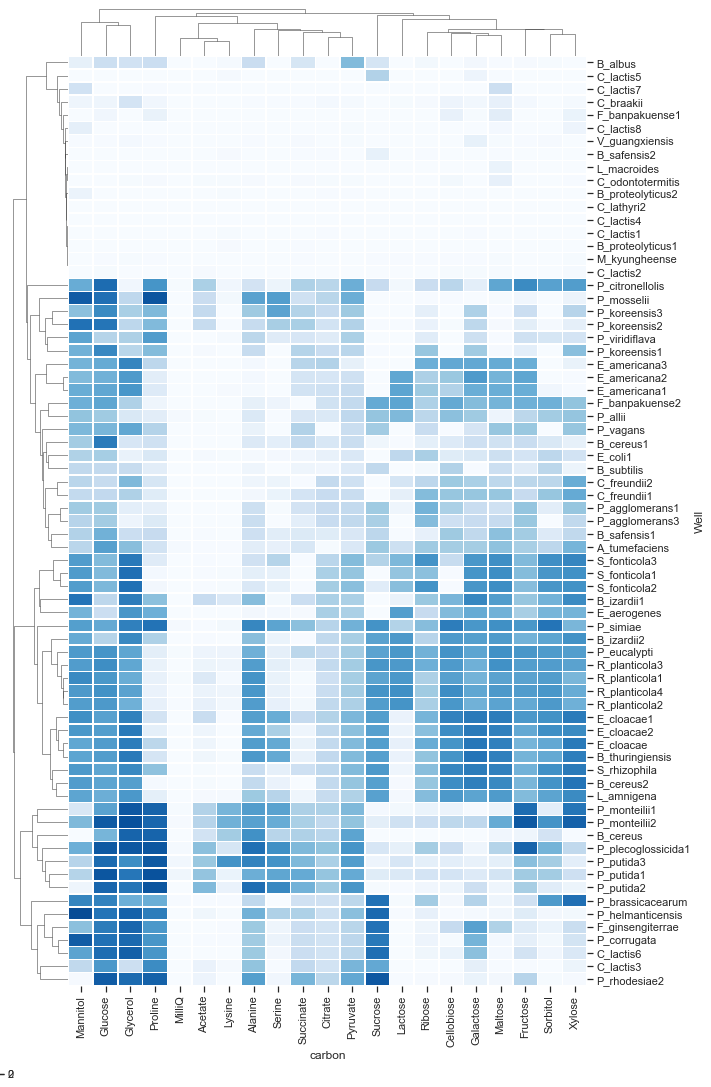

In [12]:
carbon_map=m_carbon.reset_index()
carbon_map['Well']=carbon_map['Well'].map(sample_positions_dic)
carbon_map['Well']=carbon_map['Well'].replace(phylo_dict)
carbon_map=carbon_map[carbon_map.Well.isin(phylo_dict.values())].dropna()
carbon_map=carbon_map.drop_duplicates(subset='Well')
carbon_map=carbon_map.set_index('Well')

# fig, axes = plt.subplots(1,1,figsize=(12,20))
sns.set(style='ticks', font_scale=1)
g=sns.clustermap(carbon_map, linewidths=.5, fmt='.3f', cmap='Blues',
               vmin=0, vmax=2, yticklabels=True,xticklabels=True,
               figsize=(10,15),  cbar_pos=(0, 0, 0, 0),
                dendrogram_ratio=(.1, .05),)

g.savefig('carbon_cluster.png',dpi=300, bbox_inches='tight')

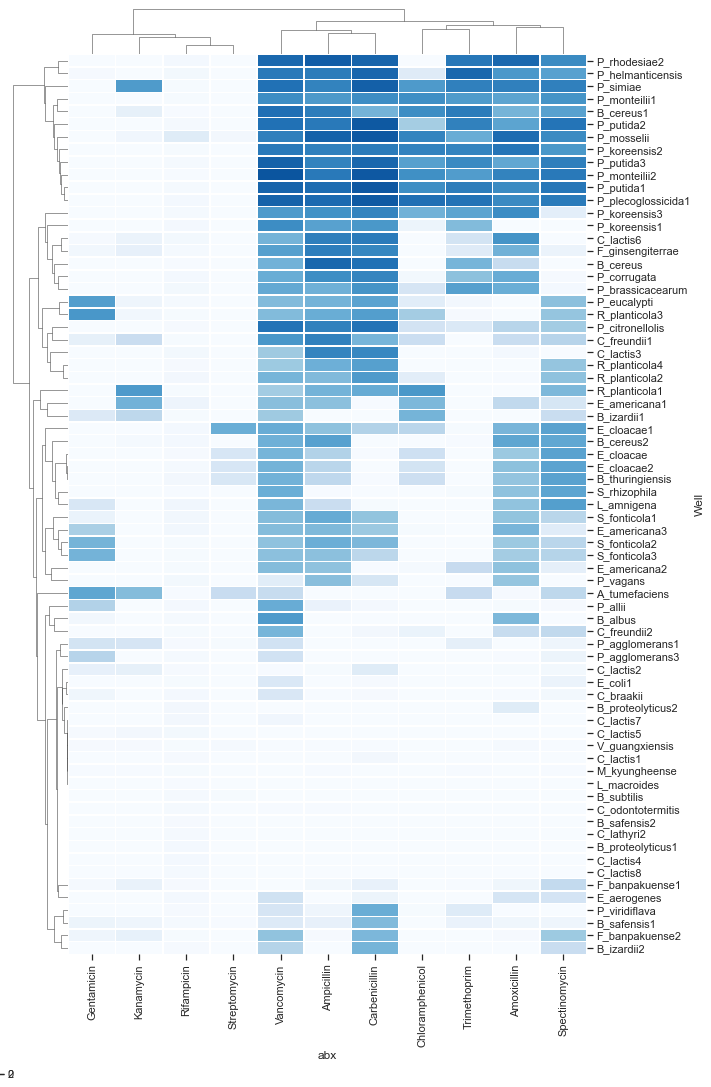

In [13]:
abx_map=m_abx.reset_index()
abx_map['Well']=abx_map['Well'].map(sample_positions_dic)
abx_map['Well']=abx_map['Well'].replace(phylo_dict)
abx_map=abx_map[abx_map.Well.isin(phylo_dict.values())].dropna()
abx_map=abx_map.drop_duplicates(subset='Well')
abx_map=abx_map.set_index('Well')

# fig, axes = plt.subplots(1,1,figsize=(12,20))
sns.set(style='ticks', font_scale=1)
g=sns.clustermap(abx_map, linewidths=.5, fmt='.3f', cmap='Blues',
               vmin=0, vmax=2, yticklabels=True,xticklabels=True,
               figsize=(10,15),  cbar_pos=(0, 0, 0, 0),
                dendrogram_ratio=(.1, .05),)
g.savefig('abx_cluster.png',dpi=300, bbox_inches='tight')

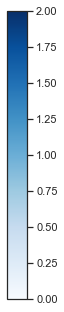

In [14]:
temp_array = np.array([[0,2]])
pl.figure(figsize=(9, 0.5))
img = pl.imshow(temp_array, cmap="Blues")
pl.gca().set_visible(False)
cax = pl.axes([0, 5, 0.03, 8])
pl.colorbar(cax=cax)
pl.savefig('blues_color_bar.png',dpi=300, bbox_inches='tight')

## Growth Curves
### Import Data

In [15]:
#remove specific samples from sample positions for this experiment

gc_sample_positions_dic=sample_positions_dic.copy()
gc_sample_positions_dic['A5']=np.nan
gc_sample_positions_dic['F7']=np.nan
gc_sample_positions_dic['H10']=np.nan

In [16]:
#Create Dataframes
epo= pd.read_excel('Data/Isolate_profiling/growth_curve_epoch2.xlsx', 
                   sheet_name='od')

#Remove blank
def normalize (row):
    
    blank=row[['A12','B12','C12','D12','E12','F12','G12','H12',]].median()
    row=(row-blank).clip(lower=0.001).round(3)
    
    return row

epo=epo.apply(normalize, axis=1)
epo["Time"]=np.arange(0,48.25,0.25)


syn= pd.read_excel('Data/Isolate_profiling/growth_curve_synergy2.xlsx',
                   sheet_name='od')

#Remove blank
def normalize (row):
    
    blank=row[['A12','B12','C12','D12','E12','F12','G12','H12',]].median()
    row=(row-blank).clip(lower=0.001).round(3)
    
    return row

syn=syn.apply(normalize, axis=1)
syn["Time"]=np.arange(0,48.25,0.25)


gc_merge=pd.concat([epo,syn]).groupby(level=0).mean()

### Plot growth curves

In [17]:
#calculate max od and time to threshhold (growth rate)
#store data in dictionaries

max_od_df=pd.DataFrame(gc_merge.max(axis=0)[1:]).reset_index()
max_od_df['Sample']=max_od_df['index'].map(sample_positions_dic)
max_od_df['Sample2']=max_od_df['Sample'].replace(phylo_dict)
max_od_dict=dict(zip(list(max_od_df.Sample2),
                           list(max_od_df[0])))
max_od_dict["Ecoli"]=max_od_dict["E_coli1"]


thresh_dict={}
thresh=[]
for i in list(gc_merge)[1:]:
    if gc_merge[i].max()>0.1:
        ttt=gc_merge[i][gc_merge[i]>(gc_merge[i].max()*0.8)].reset_index().loc[0,'index']*0.25
        thresh.append(ttt)
    else:thresh.append(np.nan)
    try: thresh_dict[phylo_dict[sample_positions_dic[i]]]=ttt
    except KeyError: continue  
        
        
#Merge in to dataframe for later use
gc_data=gc_merge.max(axis=0)[1:].to_frame().reset_index().rename(columns={'index':'well',0:'max_od'})
gc_data['time2threshold']=thresh
gc_data['sample']=gc_data['well'].map(sample_positions_dic).replace(phylo_dict)
gc_data.to_csv('Data/Isolate_profiling/gc_data.csv')


# K2: singles and pair effect experiment
## Setup
### Create lists of sample types for later use  

In [18]:
isolates=['BI', 'CB', 'CF', 'EA', 'EC1', 'EC10', 'EC11', 'EC12','EC14', 
          'EC16','EC17', 'EC18', 'EC9', 'Ecoli', 'Gh11','Gh12','Gh16',
          'Gh22', 'Gh24','Gh28', 'Gh29', 'Gh30', 'Gh35', 'Gh36','Gh38',
          'Gh40', 'Gh43', 'Gh44', 'Gh50', 'Gh54', 'Gh59', 'Gh60','Gh61',
          'Gh62', 'Gh67', 'Gh68', 'Gh9','KA', 'LA', 'OGI19-L','OGI33-L',
          'Og122', 'Og84', 'Og85', 'Og87', 'Og90','Og92', 'PAg1','PAg3', 
          'PAl', 'PH', 'PK', 'PP', 'ParPR2', 'RP1', 'RP1_A','RP1_B', 
          'RP2', 'SF1', 'SF2', 'Ut12', 'Ut14', 'Ut22']
monos=  ['Mono1','Mono2','Mono']
blanks= ['Blank1','Blank2']

timepoints=['t0','t1','t2','t3']

### Load and orginze data

In [19]:
warnings.filterwarnings("ignore")

#Pair chips with their data files
data_files=dict(zip(range(1,13),["EC_A","EC_B","EA_A","EA_B","RP1_A","RP1_B","BI_A","BI_B",
                                 "CF_A","CF_B","PAg_A","PAg_B"]))

#Load data from all chips into dictionary
chips_dict={}
for chip in range(1,13):
    chips_dict[data_files[chip]]=pd.read_csv('Data/kChip_data/k2/chip'+str(chip)+'.csv')
    
    area_mode=chips_dict[data_files[chip]]['t0_Area'].mode()[0]
    margin=area_mode*0.3
    chips_dict[data_files[chip]]=chips_dict[data_files[chip]][(chips_dict[data_files[chip]].t0_Area>(area_mode-margin)) &
                           (chips_dict[data_files[chip]].t0_Area<(area_mode+margin)) & (chips_dict[data_files[chip]].Total==2)]
    chips_dict[data_files[chip]]['chip']=chr(ord('@')+(chip%2+1))
    
#Merge replicate chips
chips_dict2={}
for focal in ["EC","EA","RP1","BI","CF","PAg"]:
    chips_dict2[focal]=chips_dict[focal+'_A'].append(chips_dict[focal+'_B'])

chips_dict=chips_dict2

## Normalize Data
- Subtract t0 value for each well individually
    - so we are measuring added biomass


In [20]:
n_chips_dict={}
for chip in chips_dict:
    df=chips_dict[chip].copy()

    #normalize each well to its own starting value
    df.t1=df.t1-df.t0
    df.t2=df.t2-df.t0
    df.t3=df.t3-df.t0
    df.t0=df.t0-df.t0
    
    #ensure no negative values or zero to avoid inf values later on
    df[timepoints]=df[timepoints].clip(lower=1)
     
    n_chips_dict[chip]=df

## QC

In [21]:
for chip in n_chips_dict:
    data=n_chips_dict[chip]
    data=data[data.sample1.isin(isolates)&data.sample2.isin(isolates)]
    
    #Check number of affecting species 
    num= (max(len(data.sample1.unique()),len(data.sample2.unique())))
    
    #check for duplicates
    duplicates= (len(data)!=len(data.drop_duplicates()))
    
    print (chip)
    print (num, duplicates)


EC
59 False
EA
60 False
RP1
60 False
BI
60 False
CF
59 False
PAg
60 False


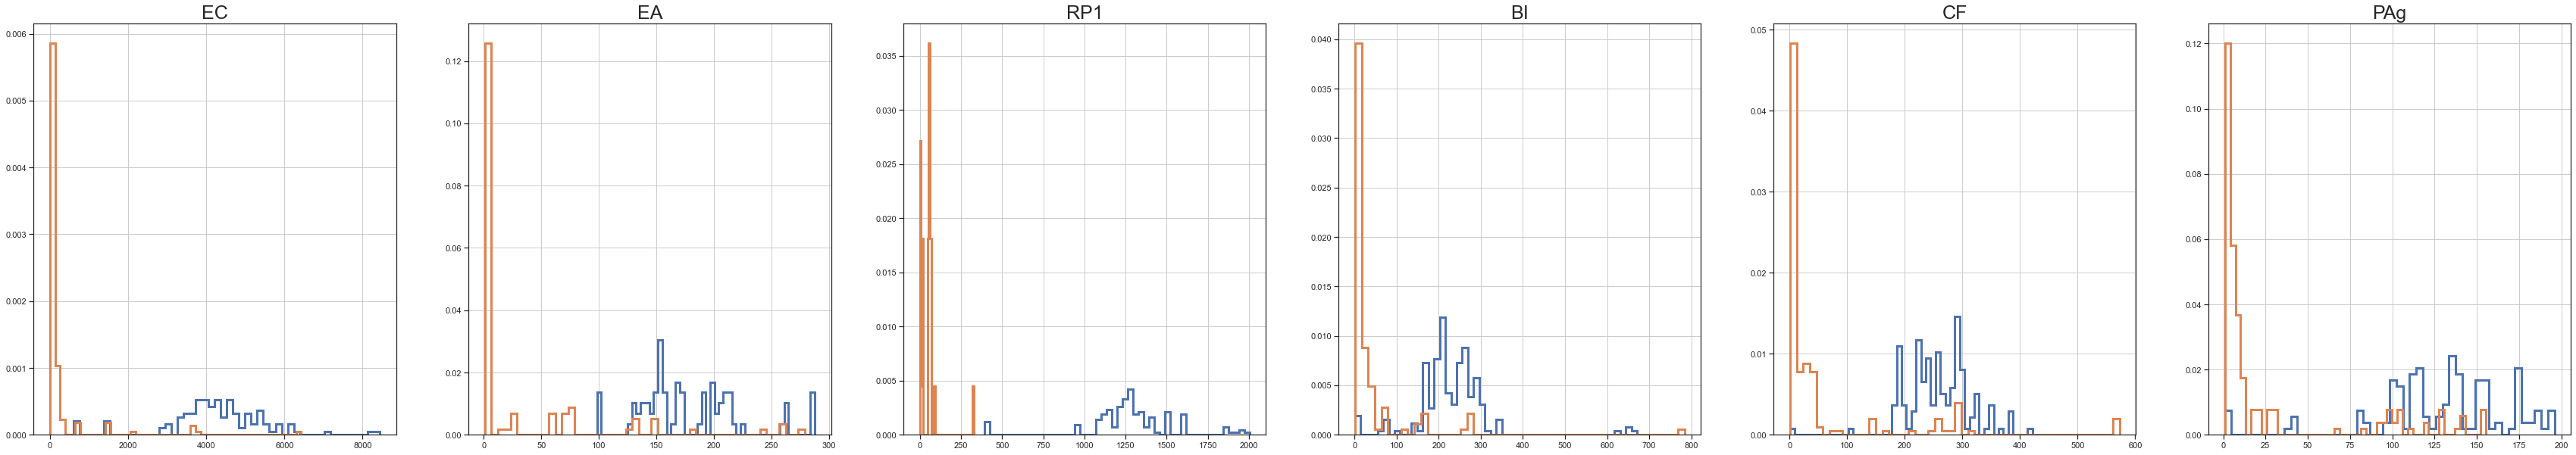

In [22]:
fig, axes = plt.subplots(1,len(n_chips_dict),figsize=(len(chips_dict)*10,10))

for ax, chip in zip(axes,n_chips_dict):
    data=n_chips_dict[chip]
    mono_df=data[(data.sample1.isin(monos)) & (data.sample2.isin(monos))].reset_index().t1
    blank_df=data[(data.sample1.isin(blanks)) & (data.sample2.isin(blanks))].reset_index().t1
    
    mono_df.hist(bins=50, lw=3, histtype='step', ax=ax, label='mono', density=True)
    blank_df.hist(bins=50, lw=3, histtype='step', ax=ax, label='blank', density=True)
    ax.set_title(chip, fontsize=25)

## Monoculture growth in chip

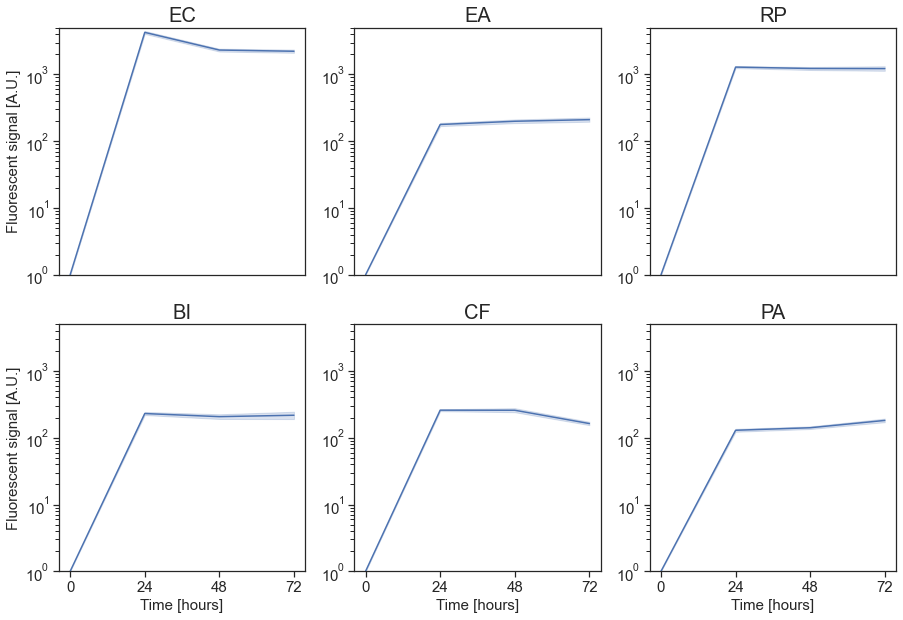

In [23]:
warnings.filterwarnings("ignore")
k2_effects_dict={}
fig, axes = plt.subplots(1,len(n_chips_dict),figsize=(15,10))
sp_counter=0

plot_title_dict={'EC':'EC','EA':'EA','BI':'BI',
                'RP1':'RP','PAg':'PA','CF':'CF',}

for chip in n_chips_dict:
    n_chips_dict[chip]['focal']=plot_title_dict[chip]
    
for chip in list(n_chips_dict.keys()):
    data=n_chips_dict[chip].copy()
    focal_mono_df=data[(data['sample1'].isin(monos))&
                           (data['sample2'].isin(monos))]

    fm_melted=focal_mono_df.melt(value_vars=timepoints,id_vars=['focal']).replace({'t0':0,'t1':24,'t2':48,'t3':72})
    
    g=plt.subplot(2, 3, sp_counter+1)
    g=sns.lineplot(data=fm_melted, x='variable', y='value')
    g.set_yscale('log')
    
    
    g.set_ylim(1,5000)

    if (sp_counter)%3==0:
        g.set_ylabel('Fluorescent signal [A.U.]',fontsize = 15)
    else:
        g.set_ylabel('',fontsize = 20)
    g.set_yticklabels(["10"+"$\mathregular{^{0}}$","10"+"$\mathregular{^{0}}$",
                       "10"+"$\mathregular{^{1}}$","10"+"$\mathregular{^{2}}$",
                       "10"+"$\mathregular{^{3}}$"],fontsize = 15)

    if sp_counter<3:
        g.set_xticks([])
        g.set_xlabel("")
    else:
        g.set_xticks([0,24,48,72])
        g.set_xticklabels([0,24,48,72], fontsize = 15)
        g.set_xlabel('Time [hours]', fontsize = 15)

    g.set_title(plot_title_dict[chip], fontsize = 20)
    
    sp_counter+=1
fig.savefig('Mono_growth_curves.png',dpi=300)

## Check if wells with mono droplet act similar to wells with two of same droplet

In [24]:
warnings.filterwarnings("ignore")
k2_effects_dict={}

for chip in list(n_chips_dict.keys()):
    tp='t1'
    data=n_chips_dict[chip].copy()
    
    #Get median mono growth to compare cocultures to
    focal_mono_median=data[(data['sample1'].isin(monos))&
                           (data['sample2'].isin(monos))][tp].median()
    effect_data=data.copy()
    
    #replace blank samples with other sample in well in dataset 
    #use both mono samples as one sample
    data[['sample1','sample2']]= data[['sample1','sample2']].replace({'Blank1':np.nan,'Blank2':np.nan,
                                                                      'Mono1':'Mono','Mono2':'Mono'})

    data.sample1 = data.sample1.fillna(data.sample2)
    data.sample2 = data.sample2.fillna(data.sample1)
    
    #get data for pair
    effect_data=data.groupby(['sample1', 'sample2'],
                             as_index=False)[tp].median()
    
    effect_data['combined_effect']=log(effect_data[tp]/focal_mono_median)
    
    effect_data['Count']=data.groupby(['sample1', 'sample2'],
                                      as_index=False)[tp].count()[tp] 
                   
    k2_effects_dict[chip]=effect_data

for chip in k2_effects_dict:
    k2_effects_dict[chip]['focal']=chip
    
#Merge into one dataframe
k2_effects_data=k2_effects_dict['EC'].copy()
for chip in list(k2_effects_dict.keys())[1:]:
    k2_effects_data=k2_effects_data.append(k2_effects_dict[chip])

In [25]:
def comm_size(row):
    #if row has the same sample twice or one focal monoculture droplet, it is a single, otherwise it is a pair
    if row['sample1']==row['sample2']: 
        row['comm_size']='single'
    elif row['sample1']=='Mono': 
        row['comm_size']='single'    
    elif row['sample2']=='Mono': 
        row['comm_size']='single'
    else: row['comm_size']='pair'    

    return row

k2_effects_data=k2_effects_data.apply(comm_size, axis=1)
k2_effects_data=k2_effects_data[k2_effects_data['Count']>2]

LinregressResult(slope=1.0449029543683939, intercept=-0.023156980092336688, rvalue=0.9801819950881625, pvalue=2.1121792703150332e-252, stderr=0.011192491079892552, intercept_stderr=0.01263270492742917)


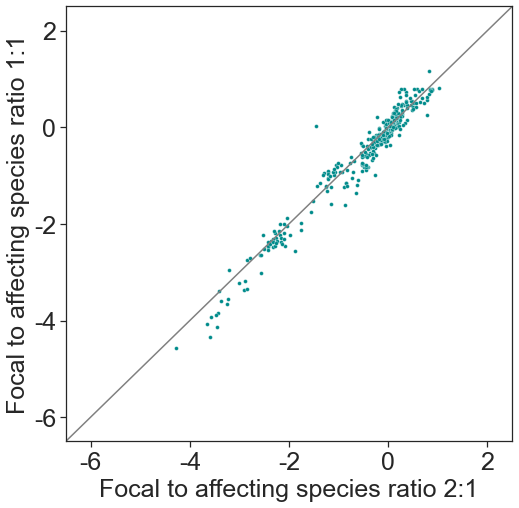

In [26]:
#create dataframe with only single wells
k2_singles=k2_effects_data[k2_effects_data.comm_size=='single'][['sample1','sample2','focal','combined_effect','Count']]

#groupby samples
k2_singles=k2_singles.groupby(['focal','sample1','sample2']).mean().reset_index()
k2_singles['Count']=k2_singles['Count']

#find wells with focal mono culrture droplet
for i in k2_singles.index:
    if k2_singles.at[i,'sample1']=='Mono' or k2_singles.at[i,'sample2']=='Mono':
        k2_singles.at[i,'Mono']='M'
    else:k2_singles.at[i,'Mono']='I'

k2_singles['droplets']=k2_singles['Mono']

#repalce mono samples with other droplet in well 
k2_singles=k2_singles.replace({'Mono':np.nan})
k2_singles['sample1']=k2_singles['sample1'].fillna(k2_singles['sample2'])
k2_singles['sample2']=k2_singles['sample2'].fillna(k2_singles['sample1'])

#create new column with the name of the focal and the affecting speices
k2_singles['pair_focal']=k2_singles['sample1']+'_'+k2_singles['focal']
k2_singles=k2_singles.dropna()

#organize data into dataset where each row has two same sample and one mono droplet values 
melted=k2_singles.melt(id_vars=['pair_focal','droplets'], value_vars=['combined_effect'],)
comp_df=pd.DataFrame(index=melted.pair_focal.unique())
for i in melted.index:
    comp_df.at[melted.at[i,'pair_focal'],melted.at[i,'droplets']]=melted.at[i,'value']


comp_df=comp_df.dropna()

#Plot
fig, axes = plt.subplots(1, 1, figsize=(8,8))

g=sns.scatterplot(data=comp_df, x='M', y='I',color='darkcyan', s=15)
g.add_line(mlines.Line2D([range(-7,4)],[range(-7,4)], color='gray'))
g.set_ylim (-6.5,2.5)
g.set_xlim (-6.5,2.5)

g.set_xticks([-6,-4,-2,0,2,])
g.set_xticklabels([-6,-4,-2,0,2,], fontsize = 25)
g.set_yticks([-6,-4,-2,0,2,])
g.set_yticklabels([-6,-4,-2,0,2,], fontsize = 25)
g.set_xlabel("Focal to affecting species ratio 2:1", fontsize = 25)
g.set_ylabel("Focal to affecting species ratio 1:1", fontsize = 25)
g.set_yticklabels(g.get_yticks().astype(int), fontsize = 25)


r=(sp.stats.linregress(list(comp_df['M']),list(comp_df['I'])))
print(r)

fig.savefig('FS11_Pa.png',dpi=300, bbox_inches='tight')

## Merge wells with mono droplets to single speices wells with two iso droplets

### Recalculate effects

In [27]:
# warnings.filterwarnings("ignore")
# k2_effects_dict={}

# for chip in list(n_chips_dict.keys()):
#     tp='t1'
#     data=n_chips_dict[chip].copy()
#     focal_mono_df=data[(data['sample1'].isin(monos))&
#                            (data['sample2'].isin(monos))][tp]
#     focal_mono_median=focal_mono_df.median()
#     effect_data=data.copy()
    
#     data[['sample1','sample2']]= data[['sample1','sample2']].replace({'RP1_A':'RP1','RP1_B':'RP1',
#                                                                       'Blank1':np.nan,'Blank2':np.nan,
#                                                                       'Mono1':np.nan,'Mono2':np.nan,
#                                                                       'Mono':np.nan})

#     data.sample1 = data.sample1.fillna(data.sample2)
#     data.sample2 = data.sample2.fillna(data.sample1)
    
#     #get data for pair
#     effect_data=data.groupby(['sample1', 'sample2'],
#                              as_index=False)[tp].median()
    
#     effect_data['combined_effect']=log(effect_data[tp]/focal_mono_median)
    
#     effect_data['Count']=data.groupby(['sample1', 'sample2'],
#                                       as_index=False)[tp].count()[tp]

#     #calculate ste via bootstapping
#     ste_df=pd.DataFrame(columns=['sample1','sample2','STE'])
#     for i in data.sample1.unique():
#         for ii in data.sample1.unique():
#             temp_data=data[(data.sample1==i)&(data.sample2==ii)]
#             s_size=len(temp_data[tp].dropna())
#             if s_size>0:
#                 bootstrap_list=[]
#                 for r in range(100):
#                     bootstrap_mono=focal_mono_df.sample(len(focal_mono_df),replace=True,random_state=r).median()
#                     bootstrap_list.append(log(((temp_data[tp].dropna().sample(s_size, replace=True)).median())/bootstrap_mono))
#                 iqr=sp.stats.iqr(bootstrap_list)

#                 ste_df.loc[len(ste_df)] = [i,ii,iqr]
    
                
#     effect_data=effect_data.merge(ste_df, on=['sample1','sample2'])  
    
# #     add data for each bug on its own
#     mono_t=(effect_data[(effect_data.sample1==effect_data.sample2)|
#                         (effect_data.sample1.isin(monos))|
#                         (effect_data.sample2.isin(monos))]
#           [['sample1','sample2','combined_effect', 'Count']])

#     mono_t.sample1=mono_t.sample1.replace(['Mono'], np.nan)
#     mono_t.sample1 = mono_t.sample1.fillna(mono_t.sample2)

#     mono_t.sample2=mono_t.sample2.replace(['Mono'], np.nan)
#     mono_t.sample2 = mono_t.sample2.fillna(mono_t.sample1)

#     mono=pd.DataFrame(mono_t.groupby(['sample1','sample2'],
#                                     as_index=False)['combined_effect'].mean())
#     mono['Count']=mono_t.groupby(['sample1','sample2'],
#                                 as_index=False)['Count'].sum()['Count']           
          
#     mono=mono.rename(columns={'combined_effect':'effect'})
    
#     mono['qual_e'] = np.where(mono['effect'] > 0, '+', '-')
    
#     monos1=mono.add_prefix('mono_s1_')
#     effect_data=effect_data.merge(monos1, left_on='sample1',
#                                   right_on='mono_s1_sample1').drop('mono_s1_sample1',axis=1)
#     monos2=mono.add_prefix('mono_s2_')
#     effect_data=effect_data.merge(monos2, left_on='sample2',
#                                   right_on='mono_s2_sample1').drop('mono_s2_sample1',axis=1)

#     effect_data['strongest'] = effect_data.apply(lambda x: max(x[["mono_s1_effect","mono_s2_effect"]],
#                                                                key=abs), axis=1)
    
#     effect_data['mean'] = effect_data[["mono_s1_effect","mono_s2_effect"]].mean(axis=1)
    
#     effect_data['additive']=(effect_data["mono_s1_effect"]+
#                              effect_data["mono_s2_effect"])
      
#     k2_effects_dict[chip]=effect_data


### Merge into single dataframe or upload from file

In [28]:
# #add focal column to each table
# for chip in k2_effects_dict:
#     k2_effects_dict[chip]['focal']=chip
    
# #merge into single dataframe
# k2_effects_data=k2_effects_dict['EC'].copy()
# for chip in list(k2_effects_dict.keys())[1:]:
#     k2_effects_data=k2_effects_data.append(k2_effects_dict[chip])

# #save to file    
# k2_effects_data.to_csv('k2_effects_data.csv')

In [29]:
k2_effects_data=(pd.read_csv('k2_effects_data.csv').drop(columns=['Unnamed: 0']))

    
k2_effects_data=(k2_effects_data[['sample1', 'sample2', 'focal','combined_effect', 'STE', 
                                  'mono_s1_effect','mono_s2_effect','strongest','mean',
                                  'additive','mono_s1_qual_e', 'mono_s2_qual_e','Count' ]]
                 .reset_index().drop(columns='index'))


## Integrating isolate profiling data 

In [30]:
phylo_dm=(pd.read_csv('Data/Isolate_profiling/phylo_distance_matrix.csv')
              .set_index('sample1')
              .replace(phylo_dict)
              .rename(columns=phylo_dict))

metabolic_dm=(pd.read_csv('Data/Isolate_profiling/metabolic_distance_matrix.csv')
              .set_index('sample2')
              .replace(phylo_dict)
              .rename(columns=phylo_dict))

abx_dm=(pd.read_csv('Data/Isolate_profiling/abx_distance_matrix.csv')
              .set_index('sample2')
              .replace(phylo_dict)
              .rename(columns=phylo_dict))
gc_data=(pd.read_csv('Data/Isolate_profiling/gc_data.csv')
         .replace(phylo_dict).drop_duplicates(subset='sample',)
         .set_index('sample'))

gc_focals_dict={'EC':'E_coli1', 'EA':'E_americana2', 'RP':'R_planticola1', 
                'CF':'C_freundii1', 'PA':'P_agglomerans1', 'BI':'B_izardii1',}

k2_effects_data[['sample1','sample2',]]=k2_effects_data[['sample1','sample2',]].replace(phylo_dict)
k2_effects_data[['focal',]]=k2_effects_data[['focal',]].replace({'RP1':'RP','PAg':'PA'})


In [31]:
#make function to calculate distance between isolates and focal
def distances(row):
    
    #retreive metabolic distance between both effecting speices (isolates) in well
    try: row['isos_mtb_distance']=metabolic_dm.at[row['sample1'],row['sample2']]
    except KeyError: row['isos_mtb_distance']=np.nan  
    
    #retreive metabolic distance between isolate1 and focal
    try: row['i1_f_mtb_distance']=metabolic_dm.at[row['sample1'],gc_focals_dict[row['focal']]]
    except KeyError: row['iso1t_mtb_distance']=np.nan  

    #retreive metabolic distance between isolate2 and focal
    try: row['i2_f_mtb_distance']=metabolic_dm.at[row['sample2'],gc_focals_dict[row['focal']]]
    except KeyError: row['iso2t_mtb_distance']=np.nan  

    #retreive resistance distance between both effecting speices (isolates) in well
    try: row['isos_abxr_distance']=abx_dm.at[row['sample1'],row['sample2']]
    except KeyError: row['isos_abxr_distance']=np.nan  

    #retreive resistance distance between isolate1 and focal
    try: row['i1_f_abxr_distance']=abx_dm.at[row['sample1'],gc_focals_dict[row['focal']]]
    except KeyError: row['iso1t_abxr_distance']=np.nan  

    #retreive resistance distance between isolate2 and focal
    try: row['i2_f_abxr_distance']=abx_dm.at[row['sample2'],gc_focals_dict[row['focal']]]
    except KeyError: row['iso2t_abxr_distance']=np.nan 
        
    #retreive phylogentetic distance between both effecting speices (isolates) in well
    try: row['isos_phg_distance']=phylo_dm.at[row['sample1'],row['sample2']]
    except KeyError: row['isos_phg_distance']=np.nan  

    #retreive phylogentetic distance between isolate1 and focal
    try: row['i1_f_phg_distance']=phylo_dm.at[row['sample1'],gc_focals_dict[row['focal']]]
    except KeyError: row['iso1t_phg_distance']=np.nan  

    #retreive phylogentetic distance between isolate2 and focal
    try: row['i2_f_phg_distance']=phylo_dm.at[row['sample2'],gc_focals_dict[row['focal']]]
    except KeyError: row['iso2t_phg_distance']=np.nan 

    #retreive growth kenteics data for each isolate 
    try: row['i1_max_od']=max_od_dict[row['sample1']]
    except KeyError: 
        row['i1_max_od']=np.nan      

    try: row['i1_time_to_thresh']=1/gc_data.at[row['sample1'],'time2threshold']
    except KeyError: row['i1_time_to_thresh']=np.nan 
        
    try: row['i2_max_od']=max_od_dict[row['sample2']]
    except KeyError: row['i1_max_od']=np.nan  

    try: row['i2_time_to_thresh']=1/gc_data.at[row['sample2'],'time2threshold']
    except KeyError: row['i2_time_to_thresh']=np.nan 
    
    return row

#make function to measure comm_size and qualitative effects
def comm_size_and_qual_effect(row):
    
    #assign community size
    if row['sample1']==row['sample2']: 
        row['comm_size']='single'
    elif row['sample1']=='Mono': 
        row['comm_size']='single'    
    elif row['sample2']=='Mono': 
        row['comm_size']='single'
    else: row['comm_size']='pair'    

    row['qual_monos']=','.join(sorted(list(row[['mono_s1_qual_e','mono_s2_qual_e']])))
  
   #define the qualitative combined effect
    if row['combined_effect']<0 and (row['combined_effect']-row['STE'])<0: 
        row['qual_effect']='Negative'
    elif row['combined_effect']<0 and (row['combined_effect']-row['STE'])>0: 
        row['qual_effect']='Neutral'
    elif row['combined_effect']>0 and (row['combined_effect']-row['STE'])<0: 
        row['qual_effect']='Neutral'
    elif row['combined_effect']>0 and (row['combined_effect']-row['STE'])>0: 
        row['qual_effect']='Positive'
        
    #calculate modified stonrgest model
    if row["mono_s1_effect"]>0 and row["mono_s2_effect"]>0:
        row['modified_strongest']=row[["mono_s1_effect","mono_s2_effect"]].max()
    else: row['modified_strongest']=row[["mono_s1_effect","mono_s2_effect"]].min()
    
    return row

k2_effects_data=k2_effects_data.apply(distances, axis=1)
k2_effects_data=k2_effects_data.apply(comm_size_and_qual_effect, axis=1)
k2_effects_data=k2_effects_data[k2_effects_data['Count']>2]

## Distirbution of Effects 
### Single speices effect vs pairs effects

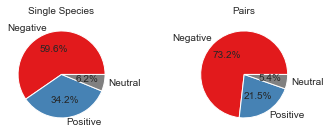

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(6,2))

axes[0].pie(k2_effects_data[k2_effects_data.comm_size=='single'].qual_effect.value_counts(), 
            colors=['#E21A1C','steelblue','gray'], wedgeprops=dict(edgecolor='w'), 
            autopct='%1.1f%%',labels=['Negative', 'Positive', 'Neutral'],textprops={'fontsize': 10})
axes[0].set_title('Single Species', fontsize = 10)

axes[1].pie(k2_effects_data[k2_effects_data.comm_size=='pair'].qual_effect.value_counts(), 
            colors=['#E21A1C','steelblue','gray'], wedgeprops=dict(edgecolor='w'), 
            autopct='%1.1f%%',labels=['Negative', 'Positive', 'Neutral'],textprops={'fontsize': 10})
axes[1].set_title('Pairs', fontsize = 10);

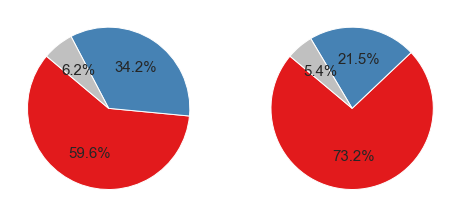

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes[0].pie(k2_effects_data[k2_effects_data.comm_size=='single'].qual_effect.value_counts(), 
            colors=['#E21A1C','steelblue','silver'], wedgeprops=dict(edgecolor='w'), startangle=140,
            autopct='%1.1f%%',textprops={'fontsize': 15});

axes[1].pie(k2_effects_data[k2_effects_data.comm_size=='pair'].qual_effect.value_counts(), 
            colors=['#E21A1C','steelblue','silver'], wedgeprops=dict(edgecolor='w'), startangle=140,
            autopct='%1.1f%%',textprops={'fontsize': 15});
fig.savefig('F2_Pcb.png', dpi=300)

In [34]:
md_list=[]
for f in k2_effects_data.focal.unique():
    temp_data=k2_effects_data[k2_effects_data.focal==f]
    md_list.append(temp_data[temp_data.comm_size=='single'].combined_effect.median()-
                   temp_data[temp_data.comm_size=='pair'].combined_effect.median())
    
print('Pair effect is more on average more negative by',mean(md_list))

print('\n\nMedian effect across all targets is: ',
      median(k2_effects_data[k2_effects_data.comm_size=='single'].combined_effect))
print('\nEffect IQR across all targets is: ',
      sp.stats.iqr(k2_effects_data[k2_effects_data.comm_size=='single'].combined_effect))

Pair effect is more on average more negative by 0.49346426757699907


Median effect across all targets is:  -0.16766054110321335

Effect IQR across all targets is:  0.9722271872165908


single v.s. pair: Mann-Whitney-Wilcoxon test two-sided, P_val=2.276e-06 U_stat=2.029e+06


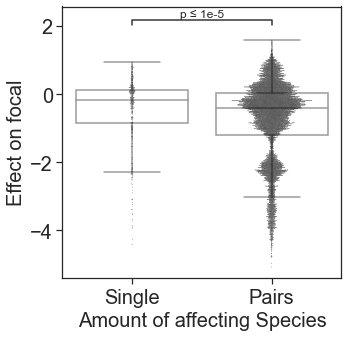

In [35]:
fig, axes = plt.subplots(1,1,figsize=(5,5))

#compare distirbution of effects for single speices and pairs across all focals
ax=sns.boxplot(data=k2_effects_data, x='comm_size', y='combined_effect',
               color='white', fliersize=0)
ax=sns.swarmplot(data=k2_effects_data, x='comm_size', y='combined_effect',
                 size=0.6, color='black')

#MWU Test 
add_stat_annotation(ax, data=k2_effects_data, x="comm_size", y="combined_effect",
                   box_pairs=[("pair", "single")],
                   test='Mann-Whitney', text_format='simple', verbose=2,
                    comparisons_correction=None)

ax.set_xlabel('Amount of affecting Species',fontsize=20)
ax.set_ylabel('Effect on focal',fontsize=20)
ax.set_xticklabels(['Single', 'Pairs'], fontsize=20)
ax.tick_params(labelsize=20)
fig.savefig('F2_Pa.png', dpi=300, bbox_inches='tight')

EC single v.s. EC pair: Mann-Whitney-Wilcoxon test two-sided, P_val=2.184e-04 U_stat=6.064e+04
EA single v.s. EA pair: Mann-Whitney-Wilcoxon test two-sided, P_val=3.621e-01 U_stat=4.311e+04
RP single v.s. RP pair: Mann-Whitney-Wilcoxon test two-sided, P_val=8.064e-03 U_stat=6.049e+04
BI single v.s. BI pair: Mann-Whitney-Wilcoxon test two-sided, P_val=4.328e-01 U_stat=5.069e+04
CF single v.s. CF pair: Mann-Whitney-Wilcoxon test two-sided, P_val=4.154e-01 U_stat=5.334e+04
PA single v.s. PA pair: Mann-Whitney-Wilcoxon test two-sided, P_val=2.250e-01 U_stat=5.772e+04


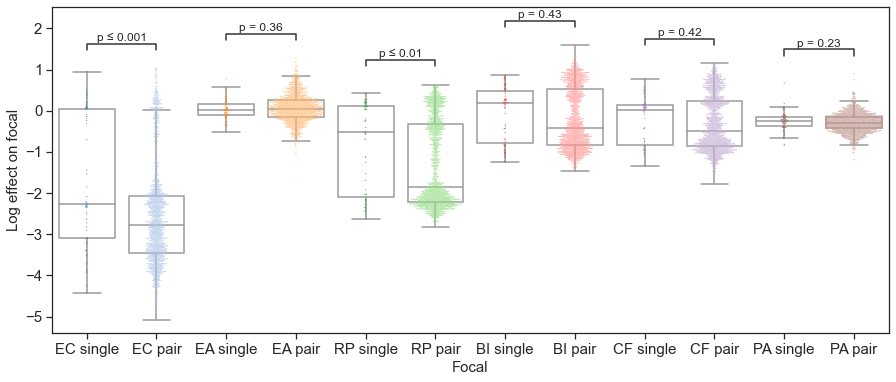

In [36]:
#compare distirbution of effects for single speices and pairs for each focal individually 

#Reorginize data to acount for comm size and focal in one coloumn
melted=k2_effects_data.melt(id_vars=['focal', 'comm_size'],value_vars='combined_effect')
melted['f_and_cs']=melted['focal']+' '+melted['comm_size']
melted

#plot data
fig, axes = plt.subplots(1,1,figsize=(15,6))

ax=sns.boxplot(data=melted, x='f_and_cs', y='value', color='white',fliersize=0)
ax=sns.swarmplot(data=melted, x='f_and_cs', y='value', size=1, palette='tab20')

add_stat_annotation(ax, data=melted, x="f_and_cs", y="value",
                   box_pairs=[('EC single', 'EC pair'), ('EA single', 'EA pair'), 
                              ('RP single','RP pair'), ('BI single', 'BI pair'),
                              ('CF single', 'CF pair'), ('PA single', 'PA pair')],
                   test='Mann-Whitney', text_format='simple', verbose=2, comparisons_correction=None)

ax.set_xlabel('Focal',fontsize=15)
ax.set_ylabel('Log effect on focal',fontsize=15)
# ax.legend(False)

ax.tick_params(labelsize=15)
fig.savefig('F2_D.png', dpi=300, transparent=True, bbox_inches='tight')

### Idividual speices and pairs' effects across focals
- looking at the lowest percentile of strenght of effects across different focal speics for single speices and pairs  

In [37]:
#create dataframe with only focal, pair, and combined effect
pairs_effect=k2_effects_data.copy()
pairs_effect['pair']=pairs_effect['sample1']+'__'+pairs_effect['sample2']
pairs_effect=pairs_effect[['focal','pair','combined_effect']]

#Get the percentile of effect strength for each pair against each focal
pairs_effect_w_p=pd.DataFrame()
for f in pairs_effect.focal.unique():
    t_df=pairs_effect[pairs_effect.focal==f]
    t_df['percentile_rank'] = abs(t_df.combined_effect).rank(pct = True)

    pairs_effect_w_p=pairs_effect_w_p.append(t_df)
    
#Ensure pairs were tested across at least four focals
pairs_effect_w_p['count']=pairs_effect['pair'].map(pairs_effect_w_p.pair.value_counts().to_dict())
pairs_effect_w_p=pairs_effect_w_p[pairs_effect_w_p['count']>4]

#create identical dataframe for single speices 
species_effect=k2_effects_data[(k2_effects_data.comm_size=='single')][['focal','sample1','combined_effect']]

species_effect_w_p=pd.DataFrame()
for f in species_effect.focal.unique():
    t_df=species_effect[species_effect.focal==f]
    t_df['percentile_rank'] = abs(t_df.combined_effect).rank(pct = True)

    species_effect_w_p=species_effect_w_p.append(t_df)

species_effect_w_p['count']=species_effect_w_p['sample1'].map(species_effect_w_p.sample1.value_counts().to_dict())
species_effect_w_p=species_effect_w_p[species_effect_w_p['count']>4]

single v.s. pair: Mann-Whitney-Wilcoxon test two-sided, P_val=2.880e-01 U_stat=5.221e+04


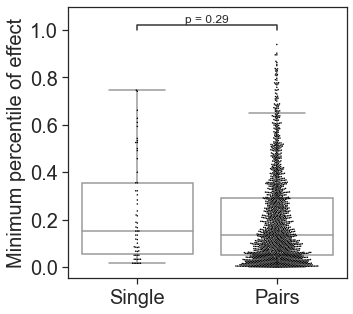

In [38]:
#Find lowest percentile effect for each species/pair 
single_min=species_effect_w_p.dropna().groupby('sample1').min()['percentile_rank'].to_frame()
single_min['comm_size']='single'

pair_min=pairs_effect_w_p.dropna().groupby('pair').min()['percentile_rank'].to_frame()
pair_min['comm_size']='pair'

#merge to one dataset
combined_mins=single_min.append(pair_min)


#plot weakest percentiles for species and pair 
fig, axes = plt.subplots(1,1,figsize=(5,5))

ax=sns.boxplot(data=combined_mins, x='comm_size', y='percentile_rank',color='white', fliersize=0)
ax=sns.swarmplot(data=combined_mins, x='comm_size', y='percentile_rank',size=1.5, color='black')

add_stat_annotation(ax, data=combined_mins, x="comm_size", y="percentile_rank",
                   box_pairs=[("pair", "single")],
                   test='Mann-Whitney', text_format='simple', verbose=2, comparisons_correction=None)

ax.set_xlabel("",fontsize=20)
ax.set_ylabel('Minimum percentile of effect',fontsize=20)
ax.set_xticklabels(['Single', 'Pairs'], fontsize=20)
ax.tick_params(labelsize=20)
fig.savefig('FS4.png', dpi=300, bbox_inches='tight')

## Single speices effects
### Do specific traits correlate with effect?

In [39]:
k2_single_data=k2_effects_data[k2_effects_data.comm_size=='single'].reset_index()

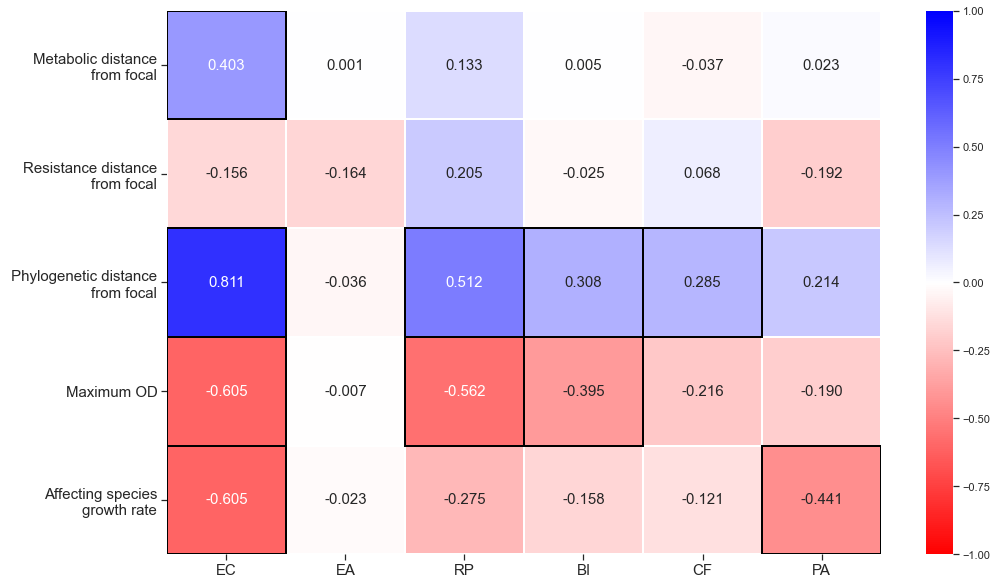

In [40]:
#Generate dataframe to look at how effects on each focal correlate to specific species traits 
corr_effects_singles=pd.DataFrame(columns=['i1_f_mtb_distance','i1_f_abxr_distance',
                                           'i1_f_phg_distance','i1_max_od',
                                           'i1_time_to_thresh',],
                                  index=['EC', 'EA','RP','BI','CF','PA'])


#generate identical dataframe for corealtation p values 
corr_effects_singles_p=corr_effects_singles.copy()

#loop through each focal and variable 
for f in corr_effects_singles.index:
    temp_data=k2_single_data[k2_single_data.focal==f]
    for v in list(corr_effects_singles): 
        #clean up data
        temp_data2=temp_data[[v,'mono_s1_effect']].replace([np.inf, -np.inf], np.nan).dropna()
        if len(temp_data2)>2:
            #run test for pearson correlation and extract r and p values to dataframes
            r=(sp.stats.linregress(temp_data2[v],temp_data2['mono_s1_effect']))
            corr_effects_singles.at[f,v]=r[2]
            corr_effects_singles_p.at[f,v]=r[3]
            
corr_effects_singles=corr_effects_singles.replace({np.nan:0})

#create dictionary for axis titles 
x_labels_dict={'i1_f_mtb_distance':'Metabolic distance\nfrom focal',
               'i1_f_abxr_distance':'Resistance distance\nfrom focal',
               'i1_f_phg_distance':' Phylogenetic distance\nfrom focal',
               'i1_max_od':'Maximum OD',
               'i1_time_to_thresh':'Affecting species\ngrowth rate'}

#plot
fig, axes = plt.subplots(1,1,figsize=(16,10))
g=sns.heatmap(corr_effects_singles.transpose(), linewidths=1, fmt='.3f', cmap='bwr_r',
            xticklabels=True,yticklabels=x_labels_dict.values(), annot=True,vmin=-1,vmax=1,
            annot_kws={'fontsize':15}) ;

sig_ps=np.where(corr_effects_singles_p.transpose()[corr_effects_singles_p.transpose() >= 0.05].isna())

#highlight statistically significant measurments
for i in range(len(sig_ps[0])):
    x_ax= (sig_ps[0][i])
    y_ax= (sig_ps[1][i])
    g.add_patch(Rectangle((y_ax, x_ax), 1, 1, ec='black', fc='none', lw=2))

plt.yticks(rotation=0, fontsize=15) 
plt.xticks(rotation=0, fontsize=15) ;
fig.savefig('FS5_Pa.png', dpi=300, bbox_inches='tight')

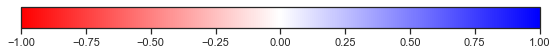

In [41]:
a = np.array([[-1,1]])
pl.figure(figsize=(9, 0.5))
img = pl.imshow(a, cmap="bwr_r")
pl.gca().set_visible(False)
cax = pl.axes([0.1, 0.2, 0.8, 0.6])
pl.colorbar(orientation="horizontal", cax=cax)

In [42]:
k2_effects_data[k2_effects_data.comm_size=='pair']

,Count,STE,additive,combined_effect,focal,i1_f_abxr_distance,i1_f_mtb_distance,i1_f_phg_distance,i1_max_od,i1_time_to_thresh,...,mono_s1_qual_e,mono_s2_effect,mono_s2_qual_e,sample1,sample2,strongest,comm_size,qual_monos,qual_effect,modified_strongest
1,28,0.070967,-5.722528,-2.621532,EC,1.748854,1.767586,0.044,0.6980,0.057971,...,-,-2.332498,-,B_izardii2,A_tumefaciens,-3.390030,pair,"-,-",Negative,-3.390030
3,34,0.196366,-7.291676,-4.289513,EC,1.748854,1.767586,0.044,0.6980,0.057971,...,-,-3.901646,-,B_izardii2,C_freundii2,-3.901646,pair,"-,-",Negative,-3.901646
4,21,0.226553,-6.234144,-3.027127,EC,1.404230,1.274946,0.166,0.9375,0.037736,...,-,-3.901646,-,A_tumefaciens,C_freundii2,-3.901646,pair,"-,-",Negative,-3.901646
6,9,0.047666,-6.492906,-3.185532,EC,1.748854,1.767586,0.044,0.6980,0.057971,...,-,-3.102876,-,B_izardii2,E_americana2,-3.390030,pair,"-,-",Negative,-3.390030
7,11,0.052500,-5.435374,-3.246695,EC,1.404230,1.274946,0.166,0.9375,0.037736,...,-,-3.102876,-,A_tumefaciens,E_americana2,-3.102876,pair,"-,-",Negative,-3.102876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10576,25,0.074370,-0.643892,-0.187832,PA,1.583806,1.683792,0.029,1.2060,0.064516,...,-,-0.306308,-,R_planticola2,P_koreensis3,-0.337585,pair,"-,-",Negative,-0.337585
10577,26,0.053920,-0.402878,-0.028082,PA,1.947215,1.753274,0.037,0.5860,0.067797,...,-,-0.306308,-,S_fonticola1,P_koreensis3,-0.306308,pair,"-,-",Negative,-0.306308
10578,26,0.101171,-0.439612,-0.139523,PA,1.973575,1.645919,0.037,0.6510,0.066667,...,-,-0.306308,-,S_fonticola2,P_koreensis3,-0.306308,pair,"-,-",Negative,-0.306308
10579,20,0.101395,-0.520985,-0.107665,PA,NaN,2.138394,0.265,0.0950,NaN,...,-,-0.306308,-,C_lathyri2,P_koreensis3,-0.306308,pair,"-,-",Negative,-0.306308


## Pair Effects

In [43]:
warnings.filterwarnings("ignore")

#create dataframe with only pairs 
k2_pair_data=k2_effects_data[k2_effects_data.comm_size=='pair']

#add accuracy column measring accuracy for each model
k2_pair_data['strongest_accuracy']=(k2_pair_data['combined_effect']-
                              k2_pair_data['strongest'])

k2_pair_data['additive_accuracy']=(k2_pair_data['combined_effect']-
                              k2_pair_data['additive'])

k2_pair_data['mean_accuracy']=(k2_pair_data['combined_effect']-
                              k2_pair_data['mean'])

#add mean distance for both isolates from focal
k2_pair_data['isos_f_mtb_distance']=(k2_pair_data["i1_f_mtb_distance"]+
                                  k2_pair_data["i2_f_mtb_distance"])/2

k2_pair_data['isos_f_abxr_distance']=(k2_pair_data["i1_f_abxr_distance"]+
                                  k2_pair_data["i2_f_abxr_distance"])/2

k2_pair_data['isos_f_phg_distance']=(k2_pair_data["i1_f_phg_distance"]+
                                  k2_pair_data["i2_f_phg_distance"])/2

#add colunm with OD weighted mena model
k2_pair_data['OD_W_mean']=(((k2_pair_data["mono_s1_effect"]*k2_pair_data["i1_max_od"])+
                             (k2_pair_data["mono_s2_effect"]*k2_pair_data["i2_max_od"]))/
                             (k2_pair_data["i1_max_od"]+k2_pair_data["i2_max_od"]))

### Fishers exact test on rise in qualitatively negative effects

In [44]:
p_neg=len(k2_single_data[k2_single_data.qual_effect=='Negative'])
p_pos=len(k2_single_data[k2_single_data.qual_effect=='Positive'])

t_neg=len(k2_pair_data[k2_pair_data.qual_effect=='Negative'])
t_pos=len(k2_pair_data[k2_pair_data.qual_effect=='Positive'])


oddsr, p = sp.stats.fisher_exact(np.array([[p_neg, p_pos], [t_neg, t_pos]]))
print ('p=',p)

p= 2.8897910397085174e-08


### Do specific trait (simlarities) correlate with effect?

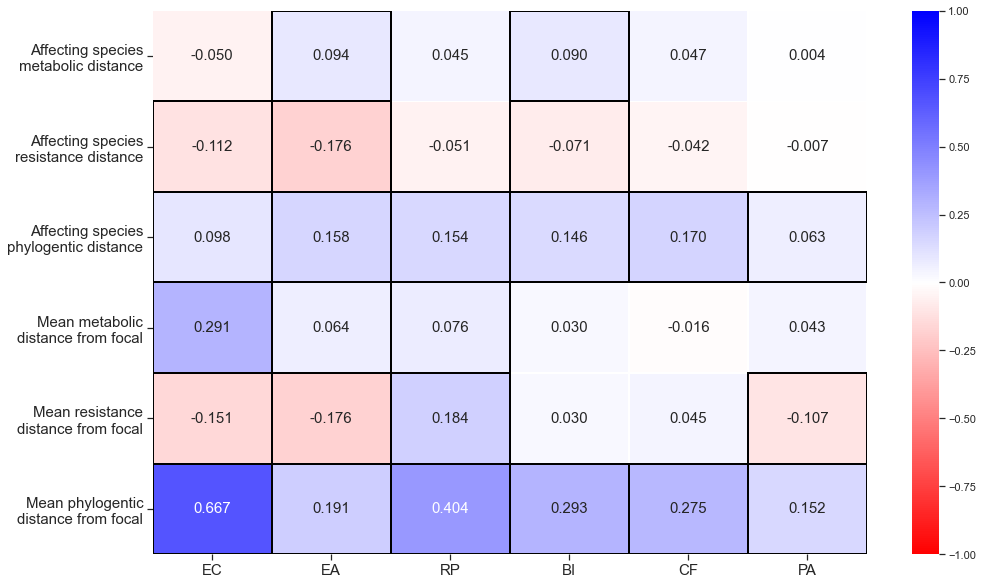

In [45]:
#Generate dataframe to look at how effects on each focal correlate to specific species traits 
corr_effects_pairs=pd.DataFrame(columns=['isos_mtb_distance','isos_abxr_distance',
                                         'isos_phg_distance',
                                         'isos_f_mtb_distance','isos_f_abxr_distance',
                                         'isos_f_phg_distance',],
                                  index=['EC', 'EA','RP','BI','CF','PA'])

#generate identical dataframe for corealtation p values
corr_effects_pairs_p=corr_effects_pairs.copy()

#loop through each focal and variable 
for f in corr_effects_pairs.index:
    temp_data=k2_pair_data[k2_pair_data.focal==f]
    for v in list(corr_effects_pairs): 
        #clean up data
        temp_data2=temp_data[[v,'combined_effect']].replace([np.inf, -np.inf], np.nan).dropna()
        if len(temp_data2)>2:
            #run test for pearson correlation and extract r and p values to dataframes
            r=(sp.stats.linregress(temp_data2[v],temp_data2['combined_effect']))
            corr_effects_pairs.at[f,v]=r[2]
            corr_effects_pairs_p.at[f,v]=r[3]


corr_effects_pairs=corr_effects_pairs.replace({np.nan:0})


fig, axes = plt.subplots(1,1,figsize=(16,10))
g=sns.heatmap(corr_effects_pairs.transpose(), linewidths=.3, fmt='.3f', cmap='bwr_r',
            xticklabels=True,yticklabels=['Affecting species\nmetabolic distance','Affecting species\nresistance distance', 
                                         'Affecting species\nphylogentic distance','Mean metabolic\ndistance from focal',
                                         'Mean resistance\ndistance from focal', 'Mean phylogentic\ndistance from focal'], 
            annot=True,vmin=-1,vmax=1, annot_kws={'fontsize':15}) ;

sig_ps=np.where(corr_effects_pairs_p.transpose()[corr_effects_pairs_p.transpose() >= 0.05].isna())

for i in range(len(sig_ps[0])):
    x_ax= (sig_ps[0][i])
    y_ax= (sig_ps[1][i])
    g.add_patch(Rectangle((y_ax, x_ax), 1, 1, ec='black', fc='none', lw=2))

plt.yticks(rotation=0, fontsize=15) 
plt.xticks(rotation=0, fontsize=15) 

fig.savefig('FS5_Pb.png', dpi=300, bbox_inches='tight');

## Predicting pairs effects based on single effects

### Import bootstrapped RMSE values

In [46]:
k2_summ_df=pd.read_csv('Data/Bootstrap_data/k2_summ_df.csv').drop(columns=['Unnamed: 0'])
k2_summ_qm_df=pd.read_csv('Data/Bootstrap_data/k2_summ_qm_df.csv').drop(columns=['Unnamed: 0'])
k2_summ_focal_df=pd.read_csv('Data/Bootstrap_data/k2_summ_focal_df.csv').drop(columns=['Unnamed: 0'])
k3_summ_df=pd.read_csv('Data/Bootstrap_data/k3_summ_df.csv').drop(columns=['Unnamed: 0'])
k3_summ_df=k3_summ_df.rename(columns={'additive_s':'additive_single','mean_s':'mean_single','strongest_s':'strongest_single',
 'additive_p':'additive_pair','mean_p':'mean_pair','strongest_p':'strongest_pair'})


# b_mean=bootstrapped_rmses.mean().to_frame().rename(columns={0:'mean'})
# b_std=bootstrapped_rmses.std().to_frame().rename(columns={0:'std'})
# bootstrapped_summary=b_mean.join(b_std,).round(2)

# bootstrap_name_dic={'expected_bliss':'K2_additive','A_mean_effect': 'K2_mean','strongest_mono': 'K2_strongest',
#                     'single_bliss': 'K3_additive_s','A_mean_effect_s': 'K3_mean_s', 'stronger_single':'K3_strongest_s',
#                     'pair_bliss': 'K3_additive_p','A_mean_effect_p': 'K3_mean_p','stronger_pair': 'K3_strongest_p'}



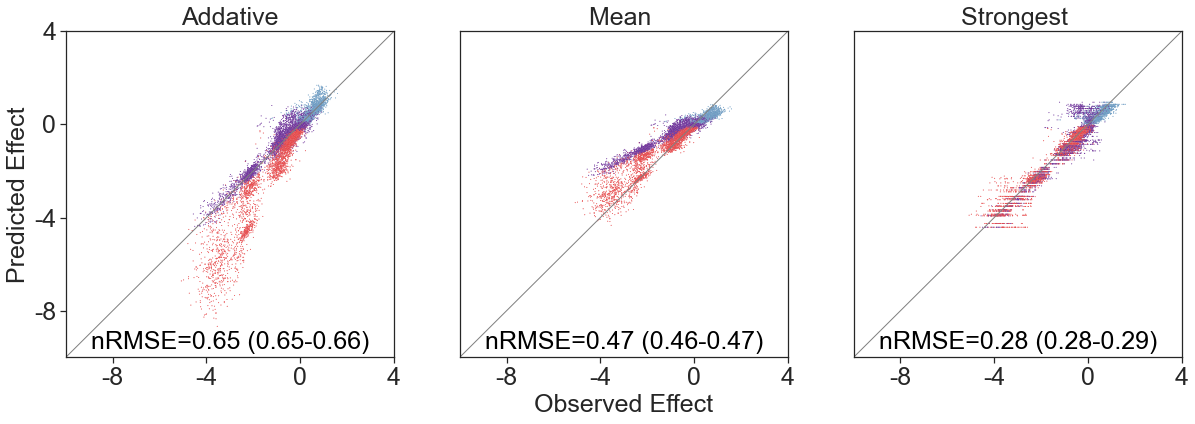

In [47]:
#generate list of models and dictionaries for plot info
models=['additive','mean', 'strongest']
x_ticks_dict={'strongest':[-6,-4,-2,0,2], 
             'mean':[-6,-4,-2,0,2], 'additive':[-8,-4,0,4],}
x_labels_dict={'strongest':'Strongest ','additive':'Addative','mean':'Mean ',
              'OD_W_mean_effect':'OD Weighted',}

#plot
fig, axes = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(20, 6))
sp_counter=1

#Get normalized RMSE for each model, and  plot model x observed 
for m in models:
    g=plt.subplot(1, 3, sp_counter)
    temp_data=k2_pair_data[[m,'combined_effect', 'qual_monos']].dropna()
    
#     #calculate RMSE and IQR for each model
#     rmse=(mean_squared_error(temp_data[m], temp_data['combined_effect']))**0.5
#     iqr=sp.stats.iqr(temp_data.combined_effect)


    #Get bootstrapped RMSE and IQR for each model
    rmse=round(k2_summ_df[m].median(), 2)
    iqr_l=np.percentile(k2_summ_df[m], 25).round(2)
    iqr_u=np.percentile(k2_summ_df[m], 75).round(2)

    g=sns.scatterplot(y=m, x="combined_effect", data=temp_data, palette=['#E21A1C', 'indigo', 'steelblue'],
                      s=1, hue='qual_monos', legend = False)
        
    #add one to one line
    g.add_line(mlines.Line2D([-10,4],[-10,4], 
                             color='grey',linewidth=1, linestyle='-',))
#     #add RMSE value
#     g.text(0.5, 0.01, "nRMSE="+str((rmse/iqr).round(2)), horizontalalignment='center', 
#                verticalalignment='bottom', transform=g.transAxes, 
#                fontdict={'fontsize':25,'color':'Black'},)
    
    #add Bootstraped RMSE value
    g.text(0.5, 0.01, "nRMSE="+str(rmse)+
           " (" + str(iqr_l)+"-" + str(iqr_u)+")", 
           horizontalalignment='center', 
               verticalalignment='bottom', transform=g.transAxes, 
               fontdict={'fontsize':25,'color':'Black'},)

    #add y ticks only to leftmost subplot
    if (sp_counter-1)%3!=0:
        g.set_yticks([])
        g.set_ylabel("")
    else:
        g.set_yticks([-8,-4,0,4])
        g.set_yticklabels([-8,-4,0,4], fontsize = 25)
        g.set_ylabel('Predicted Effect',fontsize = 25)

    g.set_ylim(-10,4)
    g.set_xlim(-10,4)

    g.set_xticks([-8,-4,0,4])
    g.set_xticklabels([-8,-4,0,4], fontsize = 25)
    g.set_title(x_labels_dict[m], fontsize = 25)
    
    #add x title to middle plot only
    if sp_counter==2: 
        g.set_xlabel('Observed Effect', fontsize = 25)
    else:g.set_xlabel('', fontsize = 25)


    sp_counter+=1
fig.savefig('F3_Pb.png',dpi=300, bbox_inches='tight')

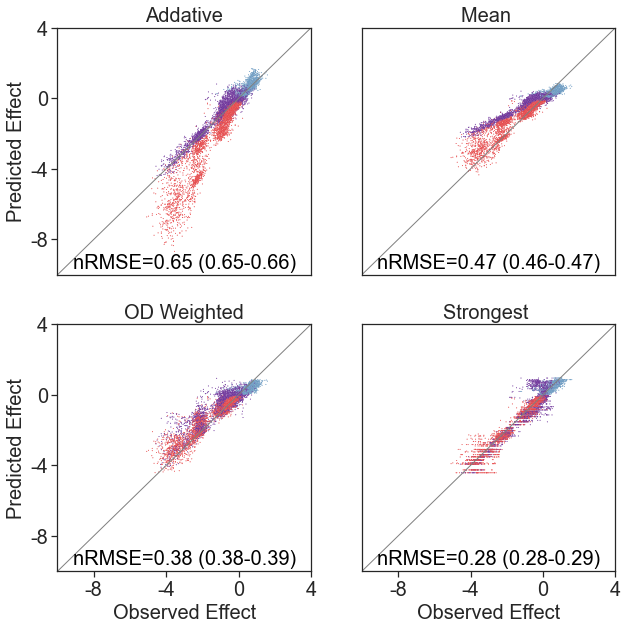

In [48]:
#generate list of models and dictionaries for plot info
models=['additive','mean','OD_W_mean','strongest']
x_labels_dict={'strongest':'Strongest ','additive':'Addative','mean':'Mean ',
              'OD_W_mean':'OD Weighted',}

#plot
fig, axes = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(10, 10))
sp_counter=1

#Get normalized RMSE for each model, and  plot model x observed 
for m in models:
    g=plt.subplot(2, 2, sp_counter)
    temp_data=k2_pair_data[[m,'combined_effect', 'qual_monos']].dropna()
    
#     #calculate RMSE and IQR for each model
#     rmse=(mean_squared_error(temp_data[m], temp_data['combined_effect']))**0.5
#     iqr=sp.stats.iqr(temp_data.combined_effect)
    
    #Get bootstrapped RMSE and IQR for each model
    rmse=round(k2_summ_df[m].median(), 2)
    iqr_l=np.percentile(k2_summ_df[m], 25).round(2)
    iqr_u=np.percentile(k2_summ_df[m], 75).round(2)

    g=sns.scatterplot(y=m, x="combined_effect", data=temp_data, palette=['#E21A1C', 'indigo', 'steelblue'],
                      s=1, hue='qual_monos', legend = False)
        
    #add one to one line
    g.add_line(mlines.Line2D([-10,4],[-10,4], 
                             color='grey',linewidth=1, linestyle='-',))
    
#     #add RMSE value
#     g.text(0.5, 0.01, "nRMSE="+str((rmse/iqr).round(2)), horizontalalignment='center', 
#                verticalalignment='bottom', transform=g.transAxes, 
#                fontdict={'fontsize':25,'color':'Black'},)
    
    #add Bootstraped RMSE value
    g.text(0.5, 0.01, "nRMSE="+str(rmse)+" (" + str(iqr_l)+"-" + str(iqr_u)+")", 
           horizontalalignment='center', verticalalignment='bottom', transform=g.transAxes, 
               fontdict={'fontsize':20,'color':'Black'},)    

    if (sp_counter-1)%2!=0:
        g.set_yticks([])
        g.set_ylabel("")
    else:
        g.set_yticks([-8,-4,0,4])
        g.set_yticklabels([-8,-4,0,4], fontsize = 20)
        g.set_ylabel('Predicted Effect',fontsize = 20)

    g.set_ylim(-10,4)
    g.set_xlim(-10,4)

    if sp_counter<3:
        g.set_xticks([])
        g.set_xlabel("")
    else:
        g.set_xticks([-8,-4,0,4])
        g.set_xticklabels([-8,-4,0,4], fontsize = 20)
        g.set_xlabel('Observed Effect', fontsize = 20)

    g.set_title(x_labels_dict[m], fontsize = 20)


    sp_counter+=1
fig.savefig('F7_Pa.png',dpi=300, bbox_inches='tight')

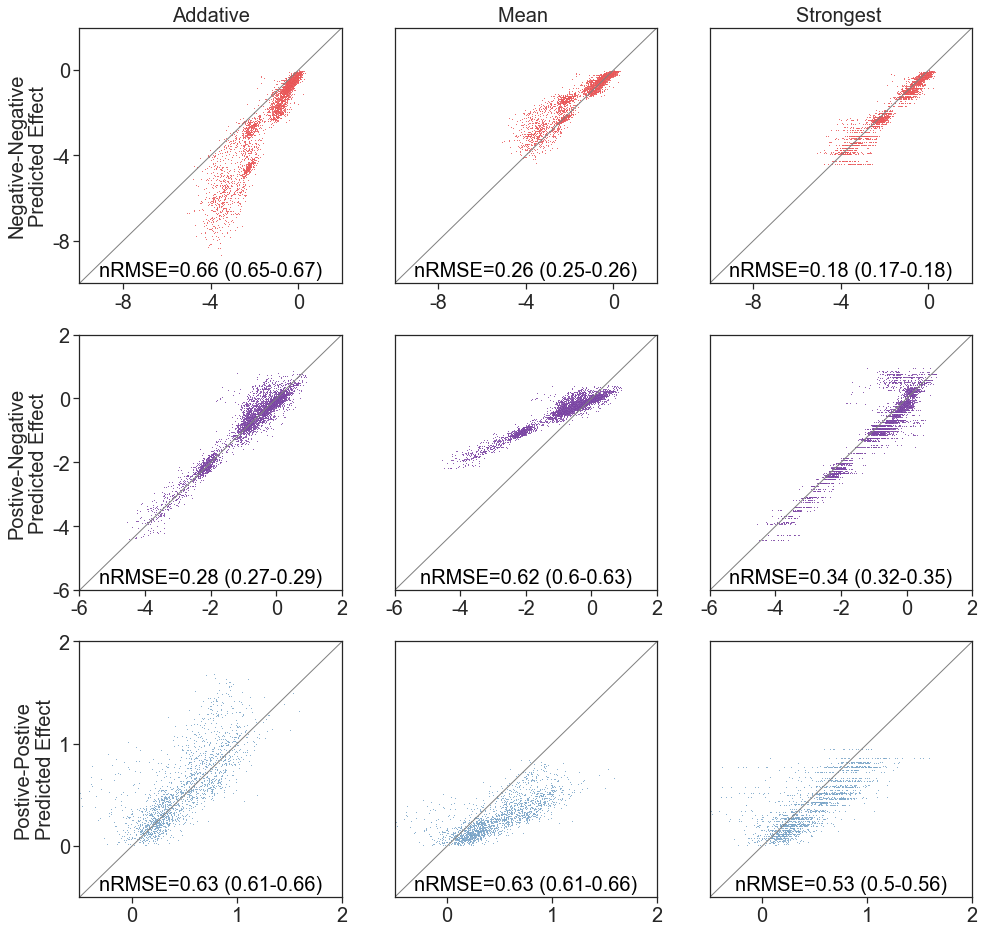

In [49]:
models=['additive','mean','strongest']

x_labels_dict={'strongest':'Strongest ','additive':'Addative','mean':'Mean '}
qm_dict={'-,-':'Negative-Negative','+,-':'Postive-Negative','+,+':'Postive-Postive'}
palette_dict={'-,-':'#E21A1C','+,-':'indigo','+,+':'steelblue'}
fig, axes = plt.subplots(sharey=True, sharex=True, figsize=(16, 16))
sp_counter=1

ticks_dict={'-,-':[-8,-4,0],'+,-':[-6,-4,-2, 0, 2],
            '+,+':[0, 1, 2]}

lims_dict={'-,-':(-10,2),'+,-':(-6,2),
           '+,+':(-0.5,2)}



for qm in k2_pair_data.qual_monos.unique():
    qual_specific=k2_pair_data[k2_pair_data.qual_monos==qm]

    for m in models:
        g=plt.subplot(3, 3, sp_counter)
        temp_data=qual_specific[[m,'combined_effect', 'qual_monos']].dropna()

    #     #calculate RMSE and IQR for each model
    #     rmse=(mean_squared_error(temp_data[m], temp_data['combined_effect']))**0.5
    #     iqr=sp.stats.iqr(temp_data.combined_effect)

        #Get bootstrapped RMSE and IQR for each model
        rmse=round(k2_summ_qm_df[qm_dict[qm]+"__"+m].median(), 2)
        iqr_l=np.percentile(k2_summ_qm_df[qm_dict[qm]+"__"+m], 25).round(2)
        iqr_u=np.percentile(k2_summ_qm_df[qm_dict[qm]+"__"+m], 75).round(2)

        g=sns.scatterplot(y=m, x="combined_effect", data=temp_data, color=palette_dict[qm],
                          s=1, legend = False)

        g.add_line(mlines.Line2D([-10,4],[-10,4], 
                                 color='grey',linewidth=1, linestyle='-',))

#     #add RMSE value
#     g.text(0.5, 0.01, "nRMSE="+str((rmse/iqr).round(2)), horizontalalignment='center', 
#                verticalalignment='bottom', transform=g.transAxes, 
#                fontdict={'fontsize':25,'color':'Black'},)
    
    #add Bootstraped RMSE value
        g.text(0.5, 0.01, "nRMSE="+str(rmse)+" (" + str(iqr_l)+"-" + str(iqr_u)+")", 
               horizontalalignment='center', verticalalignment='bottom', transform=g.transAxes, 
               fontdict={'fontsize':20,'color':'Black'},)  

        if (sp_counter-1)%3!=0:
            g.set_yticks([])
            g.set_ylabel("")
        else:
            g.set_yticks(ticks_dict[qm])
            g.set_yticklabels(ticks_dict[qm], fontsize = 20)
            g.set_ylabel(qm_dict[qm]+'\nPredicted Effect',fontsize = 20)

        g.set_ylim(lims_dict[qm])
        g.set_xlim(lims_dict[qm])

        if (sp_counter-1)<7:
            g.set_xticks(ticks_dict[qm])
            g.set_xticklabels(ticks_dict[qm], fontsize = 20)
            g.set_xlabel("")
        else:
            g.set_xticks(ticks_dict[qm])
            g.set_xticklabels(ticks_dict[qm], fontsize = 20)
        if sp_counter<4:
            g.set_title(x_labels_dict[m], fontsize = 20)
        g.set_xlabel('', fontsize = 20)


        sp_counter+=1
fig.savefig('F8B.png',dpi=300, bbox_inches='tight')

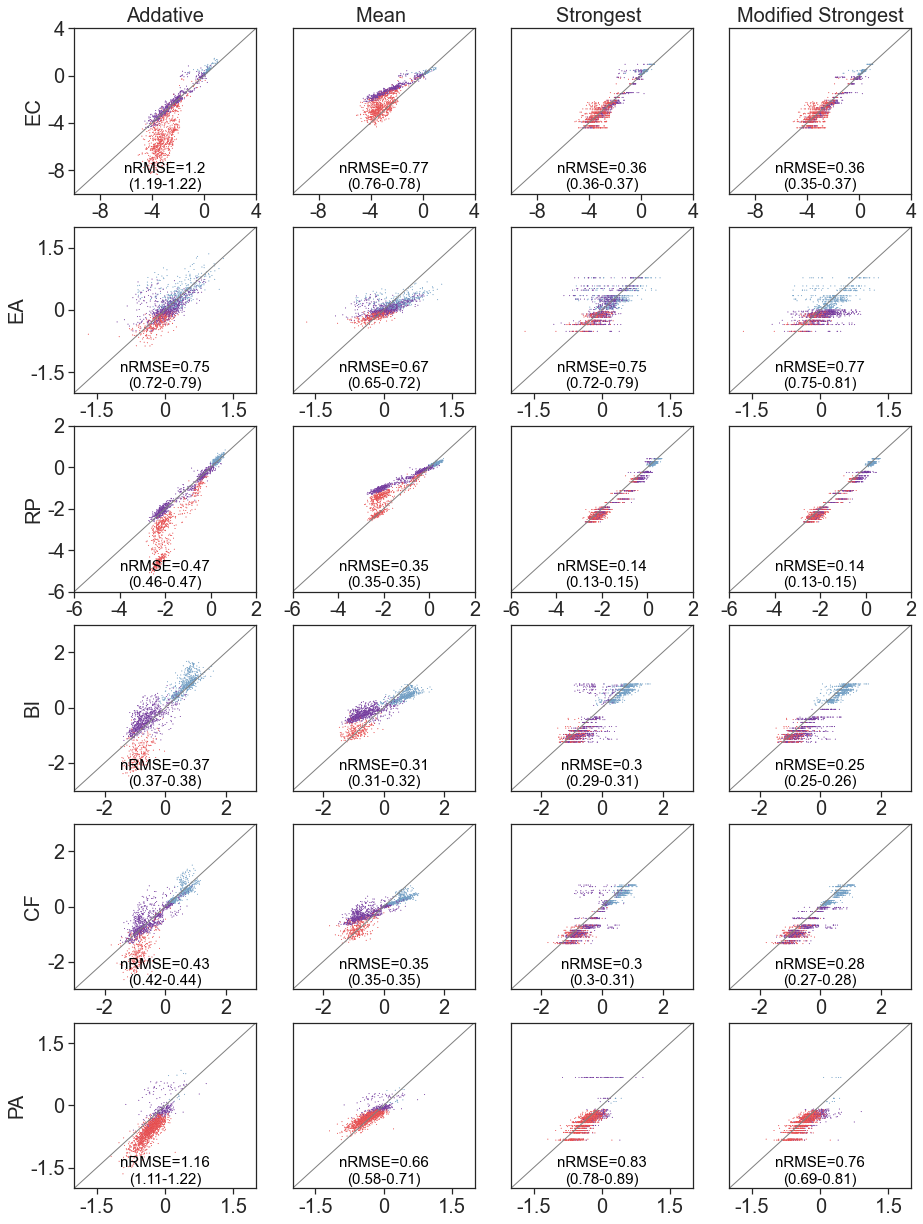

In [50]:
models=['additive','mean', 'strongest','modified_strongest']
x_labels_dict={'strongest':'Strongest ','additive':'Addative','mean':'Mean ',
              'modified_strongest':'Modified Strongest',}

rmse_focals_dict={'EC':'EC', 'EA':'EA', 'RP':'RP1', 
                'CF':'CF', 'PA':'PAg', 'BI':'BI',}

ticks_dict={'EC':[-8,-4,0,4],'EA':[-1.5, 0, 1.5],
            'RP':[-6,-4,-2, 0, 2],'BI':[-2, 0, 2], 
            'CF':[-2, 0, 2],'PA':[-1.5, 0, 1.5]}

lims_dict={'EC':(-10,4),'EA':(-2,2),
            'RP':(-6,2), 'BI':(-3,3), 
            'CF':(-3,3),'PA':(-2,2)}


fig, axes = plt.subplots(sharey=True, sharex=True, figsize=(15, 25))
sp_counter=1

for f in ['EC','EA','RP','BI','CF','PA']:
    focal_specific=k2_pair_data[k2_pair_data.focal==f]

    for m in models:
        g=plt.subplot(7, 4, sp_counter)
        temp_data=focal_specific[[m,'combined_effect', 'qual_monos']].dropna()

    #     #calculate RMSE and IQR for each model
    #     rmse=(mean_squared_error(temp_data[m], temp_data['combined_effect']))**0.5
    #     iqr=sp.stats.iqr(temp_data.combined_effect)

        #Get bootstrapped RMSE and IQR for each model
        rmse=round(k2_summ_focal_df[rmse_focals_dict[f]+"_"+m].median(), 2)
        iqr_l=np.percentile(k2_summ_focal_df[rmse_focals_dict[f]+"_"+m], 25).round(2)
        iqr_u=np.percentile(k2_summ_focal_df[rmse_focals_dict[f]+"_"+m], 75).round(2)

        g=sns.scatterplot(y=m, x="combined_effect", data=temp_data, 
                          palette={'-,-':'#E21A1C','+,-':'indigo','+,+':'steelblue'},
                          s=1, hue='qual_monos', legend = False)

        g.add_line(mlines.Line2D([-10,4],[-10,4], 
                                 color='grey',linewidth=1, linestyle='-',))

#     #add RMSE value
#     g.text(0.5, 0.01, "nRMSE="+str((rmse/iqr).round(2)), horizontalalignment='center', 
#                verticalalignment='bottom', transform=g.transAxes, 
#                fontdict={'fontsize':25,'color':'Black'},)
    
    #add Bootstraped RMSE value
        g.text(0.5, 0.01, "nRMSE="+str(rmse)+"\n(" + str(iqr_l)+"-" + str(iqr_u)+")", 
               horizontalalignment='center', verticalalignment='bottom', transform=g.transAxes, 
               fontdict={'fontsize':15,'color':'Black'},)  
        if (sp_counter-1)%4!=0:
            g.set_yticks([])
            g.set_ylabel("")
        else:
            g.set_yticks(ticks_dict[f])
            g.set_yticklabels(ticks_dict[f], fontsize = 20)
            g.set_ylabel(f,fontsize = 20)

        g.set_ylim(lims_dict[f])
        g.set_xlim(lims_dict[f])

        if (sp_counter-1)<20:
            g.set_xticks(ticks_dict[f])
            g.set_xticklabels(ticks_dict[f], fontsize = 20)
            g.set_xlabel("")
        else:
            g.set_xticks(ticks_dict[f])
            g.set_xticklabels(ticks_dict[f], fontsize = 20)
        if sp_counter<5:
            g.set_title(x_labels_dict[m], fontsize = 20)
        g.set_xlabel('', fontsize = 20)


        sp_counter+=1
fig.savefig('FS10.png',dpi=300, bbox_inches='tight')

### What affects model accuracy?
- Do qualitative effects correlate with model accuracy?
- Does difference in effect size affect model accuracy?
- Are there species traits that correlate with model accuracy?

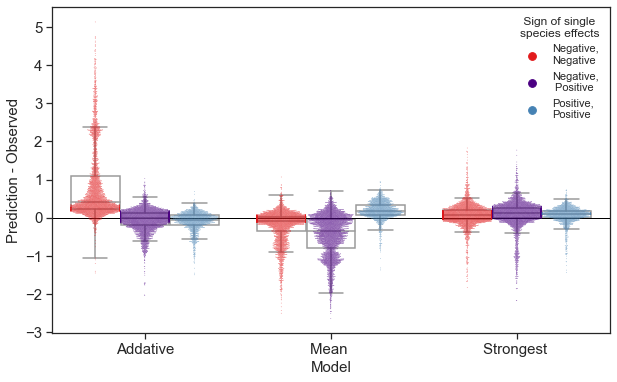

In [51]:
#generate list of models and dictionaries for plot info
models=['additive','mean', 
        'OD_W_mean','strongest']

x_labels_dict={'strongest_accuracy':'Strongest ','additive_accuracy':'Addative','mean_accuracy':'Mean ',
              'OD_W_mean':'OD Weighted',}

#organize dataframe for swarmplot (column for 2 variable columns and on value column)
melted=k2_pair_data[['strongest_accuracy','additive_accuracy',
                     'mean_accuracy','qual_monos']].melt(id_vars='qual_monos',
                                                         value_vars=['additive_accuracy',
                                                                     'mean_accuracy',
                                                                     'strongest_accuracy',]).replace(x_labels_dict)
#plot
fig, axes = plt.subplots(1, 1, figsize=(10, 6))

ax=sns.boxplot(data=melted, x='variable', y='value',  hue='qual_monos', fliersize=0,
               palette=['white','white','white',], dodge=True)

ax=sns.swarmplot(data=melted, x='variable', y='value', size=0.6, dodge=True, 
                 hue='qual_monos', palette=['#E21A1C','indigo','steelblue'])

#Add horizontal line at 0
ax.add_line(mlines.Line2D([-4,5],[0,0], 
                         color='black',linewidth=1, linestyle='-',))

#add labels and legend
ax.set_xlabel('Model',fontsize=15)
ax.set_ylabel('Prediction - Observed',fontsize=15)
ax.legend(title=' Sign of single\nspecies effects', frameon=False,
          loc='upper right', labels=['Negative,\nNegative', 
                                    'Negative,\n Positive',
                                    'Positive,\nPositive'],
         handles=ax.get_legend_handles_labels()[0][3:])



ax.tick_params(labelsize=15)
fig.savefig('FS8.png',dpi=300, bbox_inches='tight')

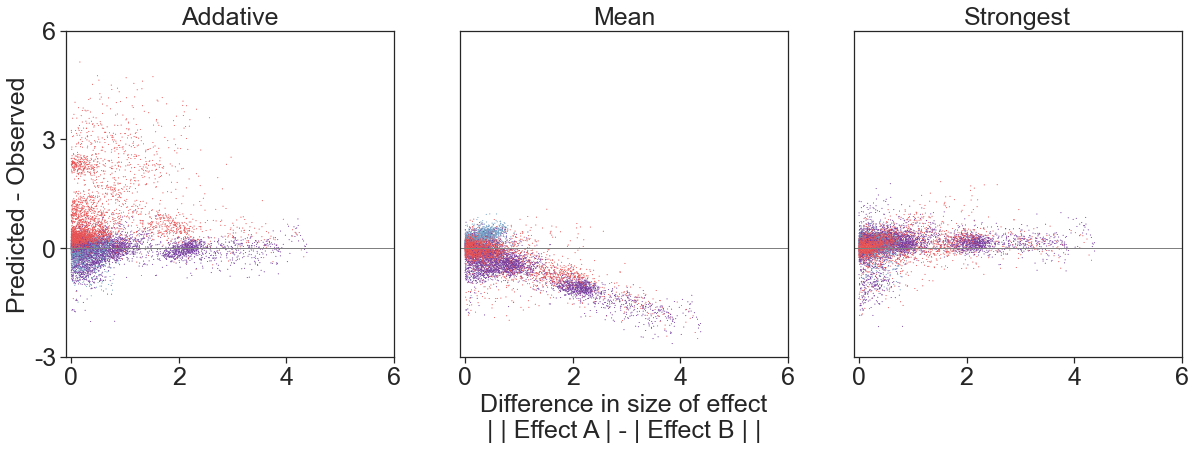

In [52]:
#generate list of models and dictionaries for plot info
x_var=['additive_accuracy','mean_accuracy','strongest_accuracy']

x_ticks_dict={'strongest_mono':[-6,-4,-2,0,2], 
             'A_mean_effect':[-6,-4,-2,0,2], 'expected_bliss':[-8,-4,0,4],}
x_labels_dict={'additive_accuracy':'Addative','mean_accuracy':'Mean', 
              'strongest_accuracy':'Strongest'}

#plot
fig, axes = plt.subplots(1, 6, sharey=True, sharex=True, figsize=(20, 6))
sp_counter=1

for v in x_var:
    g=plt.subplot(1, 3, sp_counter)
    temp_data=k2_pair_data[[v,'combined_effect', 'qual_monos',
                            'mono_s1_effect','mono_s2_effect']].dropna()
    
    #generate list of differences btween effects
    x_axis=abs((abs(temp_data['mono_s1_effect'])-abs(temp_data['mono_s2_effect'])))
    y_axis=temp_data[v]
    
    g=sns.scatterplot(x=x_axis, y=y_axis, data=temp_data,  
                      legend=False, s=1,hue='qual_monos', 
                      palette=['#E21A1C', 'indigo', 'steelblue'])
    #horizontal line at 0
    g.add_line(mlines.Line2D([-0.1,6],[0,0],color='gray',linewidth=1, linestyle='-',))

    #Y label only at leftmost subplot
    if (sp_counter-1)%3!=0:
        g.set_yticks([])
        g.set_ylabel("")
    else:
        g.set_yticks([-3,0,3,6])
        g.set_yticklabels([-3,0,3,6], fontsize = 25)
        g.set_ylabel('Predicted - Observed',fontsize = 25)

    g.set_ylim(-3,6)
    g.set_xlim(-0.1,6)

    g.set_xticks([0,2,4,6])
    g.set_xticklabels([0,2,4,6], fontsize = 25)
    g.set_title(x_labels_dict[v], fontsize = 25)
    
    #x title only on middle subplot
    if sp_counter==2: 
        g.set_xlabel('Difference in size of effect\n| | Effect A | - | Effect B | |', fontsize = 25)
    else:g.set_xlabel('', fontsize = 25)
    
    sp_counter+=1
    
fig.savefig('F3_Pc.png',dpi=300, bbox_inches='tight')

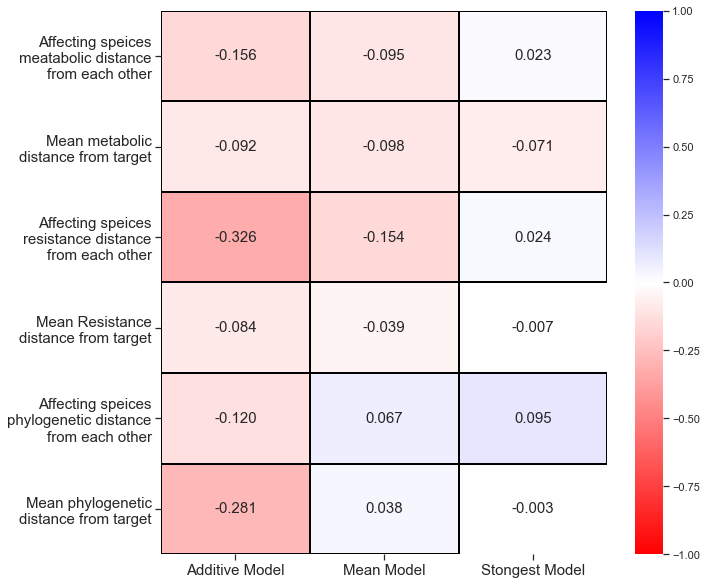

In [54]:
#Generate dataframe to look at how model accuracies correlate to specific species traits for each focal 

corr_models_pairs=pd.DataFrame(index=['isos_mtb_distance','isos_abxr_distance',
                                         'isos_phg_distance',
                                         'isos_f_mtb_distance','isos_f_abxr_distance',
                                         'isos_f_phg_distance',],
                                         columns=['additive_accuracy','mean_accuracy',
                                                  'strongest_accuracy'])
#Identical df for p values
corr_models_pairs_p_vals=corr_models_pairs.copy()

x_labels_dict={'isos_mtb_distance':'Affecting speices\nmeatabolic distance\nfrom each other',
               'isosT_mtb_distance':'Mean metabolic\ndistance from target',
               'isos_abxr_distance':'Affecting speices\nresistance distance\nfrom each other',
               'isosT_abxr_distance':'Mean Resistance\ndistance from target',
               'isos_phg_distance':'Affecting speices\nphylogenetic distance\nfrom each other',
               'isosT_phg_distance':'Mean phylogenetic\ndistance from target'}


for v in list(corr_models_pairs): 
    for m in corr_models_pairs.index: 
        data2=k2_pair_data[[v,m]].dropna()
        if len(data2)>0:
            r=(sp.stats.linregress(data2[v],data2[m]))
            corr_models_pairs.at[m,v]=r[2]
            corr_models_pairs_p_vals.at[m,v]=r[3]
            


corr_models_pairs=corr_models_pairs.replace({np.nan:0})

fig, axes = plt.subplots(1,1,figsize=(10,10))
g=sns.heatmap(corr_models_pairs, linewidths=.3, fmt='.3f', cmap='bwr_r',
            xticklabels=['Additive Model', 'Mean Model', 'Stongest Model'],
            yticklabels=x_labels_dict.values(), annot=True,vmin=-1,vmax=1,
            annot_kws={'fontsize':15}) ;

sig_ps=np.where(corr_models_pairs_p_vals[corr_models_pairs_p_vals >= 0.05].isna())

for i in range(len(sig_ps[0])):
    x_ax= (sig_ps[0][i])
    y_ax= (sig_ps[1][i])
    g.add_patch(Rectangle((y_ax, x_ax), 1, 1, ec='black', fc='none', lw=2))


plt.yticks(rotation=0, fontsize=15) 
plt.xticks(rotation=0, fontsize=15) 
fig.savefig('FS9.png', dpi=300, bbox_inches='tight')

# Trios (With E coli Focal)
## Import, organize and normalize data


In [55]:
#redefine timepoints without t3 for this experiment
timepoints=['t0','t1','t2']


#Import data
path="Data/kChip_data/k3/"
c1=pd.read_csv(path+'chip1.csv')[["t0", "t1","t2","sample1","sample2","sample3"]].dropna().replace(phylo_dict)
c2=pd.read_csv(path+'chip2.csv')[["t0", "t1","t2","sample1","sample2","sample3"]].dropna().replace(phylo_dict)
c3=pd.read_csv(path+'chip3.csv')[["t0", "t1","t2","sample1","sample2","sample3"]].dropna().replace(phylo_dict)

#label each chip seperately and merge to one dataset
c1['chip']='A'
c2['chip']='B'
c3['chip']='C'
k3=c1.append(c2).append(c3)

#normalize to t0
k3[timepoints]=k3[timepoints].sub(k3['t0'], axis=0)
k3[timepoints]=k3[timepoints].clip(lower=1).round(3)


In [56]:
# #Agregate mono growth from mono and mono+blank wells
# mono_df=pd.DataFrame(columns=list(k3))
# for i in list(itertools.product(['Mono1','Blank1'],repeat=3))[:-1]:
#     data=k3[(k3['sample1']==i[0])&(k3['sample2']==i[1])&(k3['sample3']==i[2])]
#     mono_df=mono_df.append(data)
    
# focal_mono_median=mono_df.t1.median()


# #calculate effect data for each trio
# k3_wB=k3.copy()

# #Merge wells with blanks with wells with same droplet more than once
# k3_wB[['sample1','sample2','sample3',]]=k3_wB[['sample1','sample2','sample3',]].replace(['Blank1'], np.nan)

# k3_wB.sample1 = k3_wB.sample1.fillna(k3_wB.sample2)
# k3_wB.sample1 = k3_wB.sample1.fillna(k3_wB.sample3)

# k3_wB.sample2 = k3_wB.sample2.fillna(k3_wB.sample1)
# k3_wB.sample2 = k3_wB.sample2.fillna(k3_wB.sample3)

# k3_wB.sample3 = k3_wB.sample3.fillna(k3_wB.sample1)
# k3_wB.sample3 = k3_wB.sample3.fillna(k3_wB.sample2)


# k3_effect_data=k3_wB.groupby(['sample1','sample2','sample3'], 
#                          as_index=False)['t1'].median()

# k3_effect_data['combined_effect']=log(k3_effect_data['t1']/focal_mono_median)

# k3_effect_data['Count']=k3_wB.groupby(['sample1', 'sample2','sample3'], 
#                                   as_index=False)['t1'].count()['t1']

# ste_df=pd.DataFrame(columns=['sample1','sample2','sample3','STE'])
# for i in k3_wB.sample1.unique():
#     for ii in k3_wB.sample2.unique():
#         for iii in k3_wB.sample3.unique():
#             temp_data=k3_wB[(k3_wB.sample1==i)&(k3_wB.sample2==ii)&(k3_wB.sample3==iii)]
#             s_size=len(temp_data['t1'].dropna())
#             if s_size>0:
#                 bootstrap_list=[]
#                 for r in range(100):
#                     bootstrap_mono=mono_df.sample(len(mono_df),replace=True,random_state=r).median()

#                     bootstrap_list.append(log(((temp_data['t1'].dropna().sample(s_size,replace=True))
#                                                .median())/bootstrap_mono))
#                 iqr=sp.stats.iqr(bootstrap_list)

#                 ste_df.loc[len(ste_df)] = [i,ii,iii,iqr]

# k3_effect_data=k3_effect_data.merge(ste_df, on=['sample1','sample2','sample3'])          

# #add data for each bug on its own
# mono=(k3_effect_data[(k3_effect_data.sample1==k3_effect_data.sample2)&
#                   (k3_effect_data.sample1==k3_effect_data.sample3)][['sample1','combined_effect', 
#                                                                'Count', 'STE']]
#        .rename(columns={'combined_effect':'effect'}))
# mono['qual_e'] = np.where(mono['effect'] > 0, '+', '-')

# monos1=mono.add_prefix('mono_s1_')
# k3_effect_data=k3_effect_data.merge(monos1, how='left', left_on='sample1',
#                               right_on='mono_s1_sample1').drop('mono_s1_sample1',
#                                                                axis=1)

# monos2=mono.add_prefix('mono_s2_')
# k3_effect_data=k3_effect_data.merge(monos2, how='left', left_on='sample2',
#                               right_on='mono_s2_sample1').drop('mono_s2_sample1',
#                                                                axis=1)

# monos3=mono.add_prefix('mono_s3_')
# k3_effect_data=k3_effect_data.merge(monos3, how='left', left_on='sample3',
#                               right_on='mono_s3_sample1').drop('mono_s3_sample1',
#                                                                axis=1)

# k3_effect_data=k3_effect_data[(k3_effect_data.combined_effect>-inf)&
#                         (k3_effect_data.mono_s1_effect>-inf)&
#                         (k3_effect_data.mono_s2_effect>-inf)&
#                         (k3_effect_data.mono_s3_effect>-inf)]

# k3_effect_data['additive_single']=(k3_effect_data["mono_s1_effect"]+
#                                    k3_effect_data["mono_s2_effect"]+
#                                    k3_effect_data["mono_s3_effect"])

# k3_effect_data['mean_single'] = k3_effect_data[["mono_s1_effect",
#                                                 "mono_s2_effect",
#                                                 "mono_s3_effect"]].mean(axis=1)

# k3_effect_data['strongest_single'] = k3_effect_data.apply(lambda x: max(x[["mono_s1_effect",
#                                                                            "mono_s2_effect",
#                                                                            "mono_s3_effect"]],
#                                                                               key=abs), axis=1)

# k3_effect_data.to_csv('k3_effect_data.csv')


In [57]:
k3_effect_data=pd.read_csv('k3_effect_data.csv').drop(columns=['Unnamed: 0'])
k3_effect_data=k3_effect_data.replace({'RP1': 'R_planticola4'})

In [58]:
#Define community size for each well
k3_effect_data['comm_size']=''

for i in k3_effect_data.index:
    data=k3_effect_data.loc[i]

    if ((data.sample1!=data.sample2)&
        (data.sample1!=data.sample3)&
        (data.sample2!=data.sample3)&
        (data.sample1!='Mono1')&(data.sample2!='Mono1')&(data.sample3!='Mono1')):
        
        k3_effect_data.at[i,'comm_size']='trio'
        
    elif(((data.sample1==data.sample2)&(data.sample1!=data.sample3)&
          (data.sample1!='Mono1')&(data.sample3!='Mono1'))|
         
         ((data.sample1==data.sample3)&(data.sample1!=data.sample2)&
          (data.sample1!='Mono1')&(data.sample2!='Mono1'))|
         
         ((data.sample2==data.sample3)&(data.sample2!=data.sample1)&
          (data.sample1!='Mono1')&(data.sample3!='Mono1'))|
         
         ((data.sample1=='Mono1')&(data.sample2!='Mono1')&
          (data.sample3!='Mono1')&(data.sample2!=data.sample3))|
         ((data.sample2=='Mono1')&(data.sample1!='Mono1')&
          (data.sample3!='Mono1')&(data.sample1!=data.sample3))|
         ((data.sample3=='Mono1')&(data.sample2!='Mono1')&
          (data.sample1!='Mono1')&(data.sample2!=data.sample1))):
                
            k3_effect_data.at[i,'comm_size']='pair'

    else: k3_effect_data.at[i,'comm_size']='single'

k3_effect_data=k3_effect_data[k3_effect_data['Count']>2]

In [59]:
def distances(row):
    
    try: 
        mtb_d_1_2=metabolic_dm.at[row['sample1'],row['sample2']]
        mtb_d_1_3=metabolic_dm.at[row['sample1'],row['sample3']]
        mtb_d_2_3=metabolic_dm.at[row['sample2'],row['sample3']]
        row['isos_mtb_distance']=mtb_d_1_2+mtb_d_1_3+mtb_d_2_3
        
    except KeyError: row['isos_mtb_distance']=np.nan  
        
    try: 
        mtb_d_1_t=metabolic_dm.at[row['sample1'],'E_coli1']
        mtb_d_2_t=metabolic_dm.at[row['sample2'],'E_coli1']
        mtb_d_3_t=metabolic_dm.at[row['sample3'],'E_coli1']
        row['iso_t_mtb_distance']=(mtb_d_1_t+mtb_d_2_t+mtb_d_3_t)/3
        
    except KeyError: row['iso_f_mtb_distance']=np.nan      

        
    try: 
        abx_d_1_2=abx_dm.at[row['sample1'],row['sample2']]
        abx_d_1_3=abx_dm.at[row['sample1'],row['sample3']]
        abx_d_2_3=abx_dm.at[row['sample2'],row['sample3']]
        row['isos_abx_distance']=abx_d_1_2+abx_d_1_3+abx_d_2_3
        
    except KeyError: row['isos_abx_distance']=np.nan  
        
    try: 
        abx_d_1_t=abx_dm.at[row['sample1'],'E_coli1']
        abx_d_2_t=abx_dm.at[row['sample2'],'E_coli1']
        abx_d_3_t=abx_dm.at[row['sample3'],'E_coli1']
        row['iso_t_abx_distance']=(abx_d_1_t+abx_d_2_t+abx_d_3_t)/3
        
    except KeyError: row['iso_f_abx_distance']=np.nan   

        
    try: 
        phg_d_1_2=phylo_dm.at[row['sample1'],row['sample2']]
        phg_d_1_3=phylo_dm.at[row['sample1'],row['sample3']]
        phg_d_2_3=phylo_dm.at[row['sample2'],row['sample3']]
        row['isos_phg_distance']=phg_d_1_2+phg_d_1_3+phg_d_2_3
        
    except KeyError: row['isos_phg_distance']=np.nan  
        
    try: 
        row['phg_d_1_f']=phylo_dm.at[row['sample1'],'E_coli1']
        row['phg_d_2_f']=phylo_dm.at[row['sample2'],'E_coli1']
        row['phg_d_3_f']=phylo_dm.at[row['sample3'],'E_coli1']
        row['iso_f_phg_distance']=(row['phg_d_1_f']+
                                   row['phg_d_2_f']+
                                   row['phg_d_3_f'])/3
        
    except KeyError: row['iso_t_phg_distance']=np.nan
        
        
    try: row['iso1_max_od']=max_od_dict[row['sample1']]
    except KeyError: row['iso1_max_od']=np.nan  

    try: row['iso1_time_to_thresh']=1/gc_data.at[row['sample1'],'time2threshold']
    except KeyError: row['iso1_time_to_thresh']=np.nan 
        
    try: row['iso2_max_od']=max_od_dict[row['sample2']]
    except KeyError: row['iso2_max_od']=np.nan  

    try: row['iso2_time_to_thresh']=1/gc_data.at[row['sample2'],'time2threshold']
    except KeyError: row['iso2_time_to_thresh']=np.nan 
        
    try: row['iso3_max_od']=max_od_dict[row['sample3']]
    except KeyError: row['iso3_max_od']=np.nan  

    try: row['iso3_time_to_thresh']=1/gc_data.at[row['sample3'],'time2threshold']
    except KeyError: row['iso3_time_to_thresh']=np.nan 
        
    if row['combined_effect']<0 and (row['combined_effect']-row['STE'])<0: 
        row['qual_effect']='Negative'
    elif row['combined_effect']<0 and (row['combined_effect']-row['STE'])>0: 
        row['qual_effect']='Neutral'
    elif row['combined_effect']>0 and (row['combined_effect']-row['STE'])<0: 
        row['qual_effect']='Neutral'
    else: row['qual_effect']='Positive'
        
    row['qual_monos']=','.join(sorted(list(row[['mono_s1_qual_e','mono_s2_qual_e']])))
    
    return row


k3_effect_data=k3_effect_data.apply(distances, axis=1)

## Does initial starting density affect effects?
### Single species

In [60]:
k3_singles_data=k3_effect_data[k3_effect_data.comm_size=='single']
k3_pair_data=k3_effect_data[k3_effect_data.comm_size=='pair']
k3_trio_data=k3_effect_data[k3_effect_data.comm_size=='trio']

LinregressResult(slope=1.2122883490787664, intercept=0.10712755848908517, rvalue=0.968911958194171, pvalue=1.3385430407486932e-13, stderr=0.06921758608558262, intercept_stderr=0.11190797698273237)


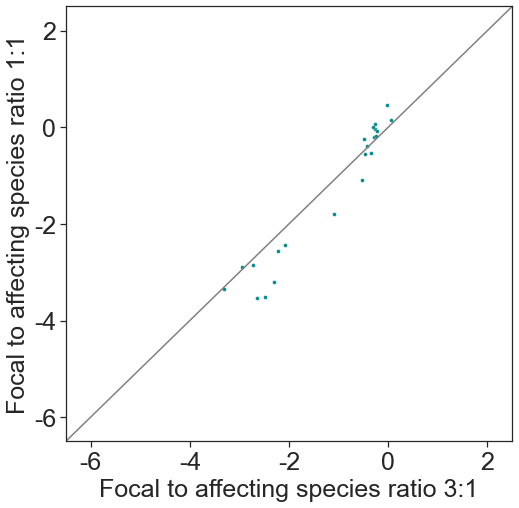

In [61]:
#merge monoa and mono2 samples to one sample 
k3_singles_data=k3_singles_data.replace({'Mono1':'Mono','Mono2':'Mono'})

#group by samples in well 
singles_gb=(k3_singles_data.groupby(['sample1','sample2','sample3']).mean()
            .reset_index())[['sample1','sample2','sample3','combined_effect']]

#check for mono doprlets in well
for i in singles_gb.index:
    if singles_gb.at[i,'sample1']=='Mono':
        singles_gb.at[i,'s1']='M'
    else:singles_gb.at[i,'s1']='I'
    
    if singles_gb.at[i,'sample2']=='Mono':
        singles_gb.at[i,'s2']='M'
    else:singles_gb.at[i,'s2']='I'
    
    if singles_gb.at[i,'sample3']=='Mono':
        singles_gb.at[i,'s3']='M'
    else:singles_gb.at[i,'s3']='I'

singles_gb['droplets']=singles_gb['s1']+'_'+singles_gb['s2']+'_'+singles_gb['s3']

#merge wells be sample regardless of mono or not (after this ha been recorded)
singles_gb=singles_gb.replace({'Mono':np.nan})
singles_gb['sample1']=singles_gb['sample1'].fillna(singles_gb['sample2'])
singles_gb['sample1']=singles_gb['sample1'].fillna(singles_gb['sample3'])
singles_gb['sample2']=singles_gb['sample2'].fillna(singles_gb['sample1'])
singles_gb['sample2']=singles_gb['sample2'].fillna(singles_gb['sample3'])
singles_gb['sample3']=singles_gb['sample3'].fillna(singles_gb['sample1'])
singles_gb['sample3']=singles_gb['sample3'].fillna(singles_gb['sample2'])
singles_gb['AffectingS']=singles_gb['sample1']

#orginze data for comparison
melted=singles_gb.melt(id_vars=['AffectingS','droplets'], value_vars=['combined_effect'],)

comp_df=pd.DataFrame(index=melted.AffectingS.unique())
for i in melted.index:
    comp_df.at[melted.at[i,'AffectingS'],melted.at[i,'droplets']]=melted.at[i,'value']

comp_df['M_M_I']=comp_df['M_M_I'].fillna(comp_df['I_M_M'])
comp_df['M_I_I']=comp_df['M_I_I'].fillna(comp_df['I_I_M'])
comp_df=comp_df[['I_I_I','M_M_I','M_I_I']].dropna()


#Plot
fig, axes = plt.subplots(1, 1, figsize=(8,8))

g=sns.scatterplot(data=comp_df, x='M_M_I', y='I_I_I',color='darkcyan', s=15)
g.add_line(mlines.Line2D([range(-7,4)],[range(-7,4)], color='gray'))
g.set_ylim (-6.5,2.5)
g.set_xlim (-6.5,2.5)

g.set_xticks([-6,-4,-2,0,2,])
g.set_xticklabels([-6,-4,-2,0,2,], fontsize = 25)
g.set_yticks([-6,-4,-2,0,2,])
g.set_yticklabels([-6,-4,-2,0,2,], fontsize = 25)
g.set_xlabel("Focal to affecting species ratio 3:1", fontsize = 25)
g.set_ylabel("Focal to affecting species ratio 1:1", fontsize = 25)
g.set_yticklabels(g.get_yticks().astype(int), fontsize = 25)


r=(sp.stats.linregress(list(comp_df['M_M_I']),list(comp_df['I_I_I'])))
print(r)

fig.savefig('FS11_Pb.png',dpi=300, bbox_inches='tight')

LinregressResult(slope=1.2122883490787664, intercept=0.10712755848908517, rvalue=0.968911958194171, pvalue=1.3385430407486932e-13, stderr=0.06921758608558262, intercept_stderr=0.11190797698273237)


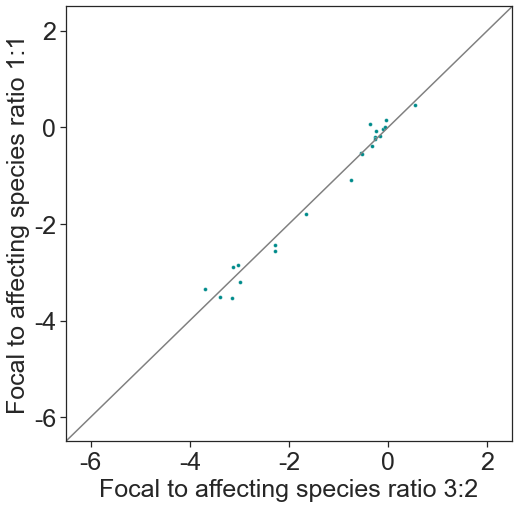

In [62]:
#Plot
fig, axes = plt.subplots(1, 1, figsize=(8,8))

g=sns.scatterplot(data=comp_df, x='M_I_I', y='I_I_I',color='darkcyan', s=15)
g.add_line(mlines.Line2D([range(-7,4)],[range(-7,4)], color='gray'))
g.set_ylim (-6.5,2.5)
g.set_xlim (-6.5,2.5)

g.set_xticks([-6,-4,-2,0,2,])
g.set_xticklabels([-6,-4,-2,0,2,], fontsize = 25)
g.set_yticks([-6,-4,-2,0,2,])
g.set_yticklabels([-6,-4,-2,0,2,], fontsize = 25)
g.set_xlabel("Focal to affecting species ratio 3:2", fontsize = 25)
g.set_ylabel("Focal to affecting species ratio 1:1", fontsize = 25)
g.set_yticklabels(g.get_yticks().astype(int), fontsize = 25)
r=(sp.stats.linregress(list(comp_df['M_M_I']),list(comp_df['I_I_I'])))
print(r)


### Pairs

LinregressResult(slope=0.9575049881392325, intercept=-0.17498001595426427, rvalue=0.9613374115903218, pvalue=2.1324286157556386e-242, stderr=0.013242139983848353, intercept_stderr=0.03427985822434478)


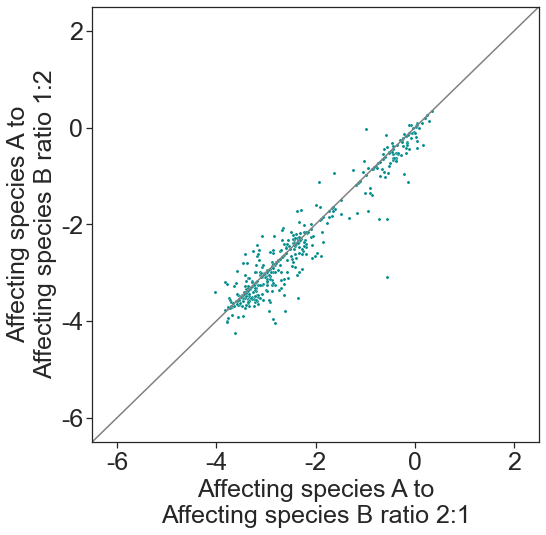

In [63]:
k3_pair_no_mono=k3_pair_data.replace(['Mono1'], np.nan)
k3_pair_no_mono=k3_pair_no_mono.dropna(subset=['sample1','sample2','sample3'])

#add column for with pair for each row
k3_pair_no_mono['trio'] =((k3_pair_no_mono[['sample1','sample2','sample3']]).values.tolist())
k3_pair_no_mono['pair'] = k3_pair_no_mono.apply(lambda x: sorted(list(set(x['trio']))),axis=1)
k3_pair_no_mono['pair'] = k3_pair_no_mono.apply(lambda x: (str(x['pair'])),axis=1)
k3_pair_no_mono['trio'] = k3_pair_no_mono.apply(lambda x: (str(x['trio'])),axis=1)

#organize data for comparison between diff starting densities
melted=k3_pair_no_mono.melt(id_vars=['pair'], value_vars=['combined_effect'],)
k3_pair_pairs=pd.DataFrame(columns=['pair','ratio1','ratio2'],index=range(len(list(melted.pair.unique()))))

#new dataset with 2:1 and 1:2 ratios in each row
for n,i in enumerate(list(melted.pair.unique())):
    if len(melted[melted.pair==i])==2:
        k3_pair_pairs.loc[n]['pair']=i
        k3_pair_pairs.loc[n]['ratio1']=list((melted[melted.pair==i]).value)[0]
        k3_pair_pairs.loc[n]['ratio2']=list((melted[melted.pair==i]).value)[1]
    elif len(melted[melted.pair==i])==1:
        k3_pair_pairs.loc[n]['pair']=i
        k3_pair_pairs.loc[n]['ratio1']=list((melted[melted.pair==i]).value)[0]
        k3_pair_pairs.loc[n]['ratio2']=list((melted[melted.pair==i]).value)[0]

    else: continue
        
#create dictionary with mean pair effects for later use in predicting trios
pair_effect_dict=melted.groupby('pair').mean()['value'].to_dict()

#plot
fig, axes = plt.subplots(1,1,figsize=(8,8))

k3_pair_pairs=k3_pair_pairs.dropna()
r=(sp.stats.linregress(list(k3_pair_pairs['ratio1']),list(k3_pair_pairs['ratio2'])))
print (r)

g=sns.scatterplot(data=k3_pair_pairs, x='ratio1', y='ratio2',
                  color='darkcyan', s=10,)

g.add_line(mlines.Line2D([range(-7,4)],[range(-7,4)], color='gray'))
g.set_ylim (-6.5,2.5)
g.set_xlim (-6.5,2.5)

g.set_xticks([-6,-4,-2,0,2,])
g.set_xticklabels([-6,-4,-2,0,2,], fontsize = 25)
g.set_yticks([-6,-4,-2,0,2,])
g.set_yticklabels([-6,-4,-2,0,2,], fontsize = 25)
g.set_xlabel("Affecting species A to\nAffecting species B ratio 2:1", fontsize = 25)
g.set_ylabel("Affecting species A to\nAffecting species B ratio 1:2", fontsize = 25)
g.set_yticklabels(g.get_yticks().astype(int), fontsize = 25)

plt.show()
fig.savefig('FS11_Pc.png',dpi=300, bbox_inches='tight')

### merge wells with mono droplet to wells with out for singles and pairs


In [64]:
#singles
k3_singles_data[['sample1','sample2','sample3',]]=k3_singles_data[['sample1','sample2','sample3',]].replace(['Mono1'], np.nan)

k3_singles_data.sample1 = k3_singles_data.sample1.fillna(k3_singles_data.sample2)
k3_singles_data.sample1 = k3_singles_data.sample1.fillna(k3_singles_data.sample3)

k3_singles_data.sample2 = k3_singles_data.sample2.fillna(k3_singles_data.sample1)
k3_singles_data.sample2 = k3_singles_data.sample2.fillna(k3_singles_data.sample3)

k3_singles_data.sample3 = k3_singles_data.sample3.fillna(k3_singles_data.sample1)
k3_singles_data.sample3 = k3_singles_data.sample3.fillna(k3_singles_data.sample2)

#pairs
k3_pair_data[['sample1','sample2','sample3',]]=k3_pair_data[['sample1','sample2','sample3',]].replace(['Mono1'], np.nan)

k3_pair_data.sample1 = k3_pair_data.sample1.fillna(k3_pair_data.sample2)
k3_pair_data.sample1 = k3_pair_data.sample1.fillna(k3_pair_data.sample3)

k3_pair_data.sample2 = k3_pair_data.sample2.fillna(k3_pair_data.sample1)
k3_pair_data.sample2 = k3_pair_data.sample2.fillna(k3_pair_data.sample3)

k3_pair_data.sample3 = k3_pair_data.sample3.fillna(k3_pair_data.sample1)
k3_pair_data.sample3 = k3_pair_data.sample3.fillna(k3_pair_data.sample2)

In [65]:
#add column for with pair for each row
k3_pair_data['trio'] =((k3_pair_data[['sample1','sample2','sample3']]).values.tolist())
k3_pair_data['pair'] = k3_pair_data.apply(lambda x: sorted(list(set(x['trio']))),axis=1)
k3_pair_data['pair'] = k3_pair_data.apply(lambda x: (str(x['pair'])),axis=1)
k3_pair_data['trio'] = k3_pair_data.apply(lambda x: (str(x['trio'])),axis=1)

#organize data for comparison between diff starting densities
melted=k3_pair_data.melt(id_vars=['pair',], value_vars=['combined_effect'],)
k3_pair_pairs=pd.DataFrame(columns=['pair','ratio1','ratio2','ratio3'],index=range(len(list(melted.pair.unique()))))

#new dataset with 2:1 and 1:2 ratios in each row
for n,i in enumerate(list(melted.pair.unique())):
    if len(melted[melted.pair==i])==3:
        k3_pair_pairs.loc[n]['pair']=i
        k3_pair_pairs.loc[n]['ratio1']=(list((melted[melted.pair==i]).value))[0]
        k3_pair_pairs.loc[n]['ratio2']=(list((melted[melted.pair==i]).value))[1]
        k3_pair_pairs.loc[n]['ratio3']=(list((melted[melted.pair==i]).value))[2]
    elif len(melted[melted.pair==i])==2:
        k3_pair_pairs.loc[n]['pair']=i
        k3_pair_pairs.loc[n]['ratio1']=(list((melted[melted.pair==i]).value))[0]
        k3_pair_pairs.loc[n]['ratio2']=(list((melted[melted.pair==i]).value))[1]

#16 pairs only have one ratio, but are included here to use in the dictionary downstream 
    elif len(melted[melted.pair==i])==1:
        k3_pair_pairs.loc[n]['pair']=i
        k3_pair_pairs.loc[n]['ratio1']=(list((melted[melted.pair==i]).value))[0]
        k3_pair_pairs.loc[n]['ratio2']=(list((melted[melted.pair==i]).value))[0]

    else: continue
        
#create dictionary with mean pair effects for later use in predicting trios
pair_effect_dict=melted.groupby('pair').mean()['value'].to_dict()


## Trio Effects
### calculate predictions based on pairs
- predictions based on single species and pairs

In [66]:
def trio_effects(row):
    
    #retreave effects of pairs making up each trio
    try:
        row['pair_12_effect']=pair_effect_dict["['"+row['sample1']+"', '"
                                               +row['sample2']+"']"]
    except KeyError:
        try:
            row['pair_12_effect']=pair_effect_dict["['"+row['sample2']+"', '"
                                               +row['sample1']+"']"]
        except KeyError: row['pair_12_effect']=np.nan
            
    try:
        row['pair_13_effect']=pair_effect_dict["['"+row['sample1']+"', '"
                                               +row['sample3']+"']"]
    except KeyError:
        try:
            row['pair_13_effect']=pair_effect_dict["['"+row['sample3']+"', '"
                                               +row['sample1']+"']"]
        except KeyError: row['pair_13_effect']=np.nan
            
    try:
        row['pair_23_effect']=pair_effect_dict["['"+row['sample3']+"', '"
                                               +row['sample2']+"']"]
    except KeyError:
        try:
            row['pair_23_effect']=pair_effect_dict["['"+row['sample2']+"', '"
                                               +row['sample3']+"']"]
        except KeyError: row['pair_23_effect']=np.nan
  
    return row

k3_trio_data=k3_trio_data.apply(trio_effects, axis=1)

#Calculate models based on pair data
k3_trio_data['additive_pair']=(k3_trio_data["pair_12_effect"]+
                                   k3_trio_data["pair_13_effect"]+
                                   k3_trio_data["pair_23_effect"])

k3_trio_data['mean_pair'] = k3_trio_data[["pair_12_effect",
                                          "pair_13_effect",
                                          "pair_23_effect"]].mean(axis=1)

k3_trio_data['strongest_pair'] = k3_trio_data.apply(lambda x: max(x[["pair_12_effect",
                                                                     "pair_13_effect",
                                                                     "pair_23_effect"]],
                                                                  key=abs), axis=1)

k3_trio_data['OD_W_mean']=(((k3_trio_data["mono_s1_effect"]*k3_trio_data["iso1_max_od"])+
                            (k3_trio_data["mono_s2_effect"]*k3_trio_data["iso2_max_od"])+
                            (k3_trio_data["mono_s3_effect"]*k3_trio_data["iso3_max_od"]))/
                            (k3_trio_data["iso1_max_od"]+k3_trio_data["iso2_max_od"]+
                            k3_trio_data["iso3_max_od"]))

### Predicting trio effects from single speices

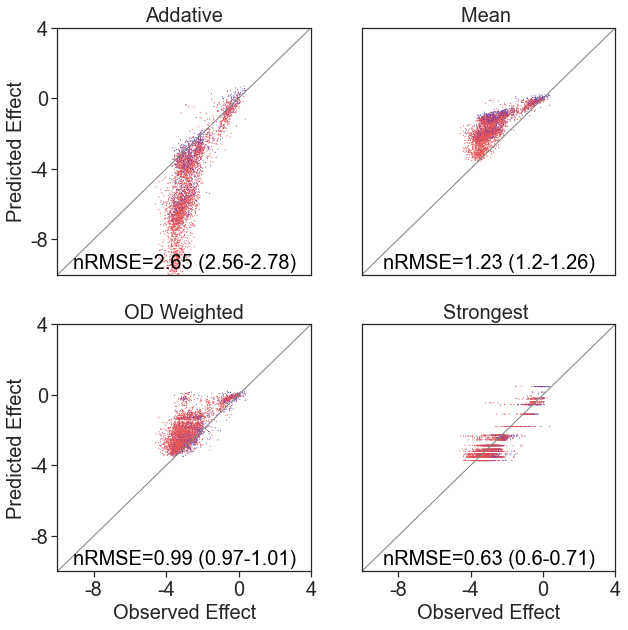

In [67]:
#generate list of models and dictionaries for plot info
models=['additive_single','mean_single', 
        'OD_W_mean','strongest_single',]
x_labels_dict={'strongest_single':'Strongest ','additive_single':'Addative','mean_single':'Mean ',
              'OD_W_mean':'OD Weighted',}

#plot
fig, axes = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(10, 10))
sp_counter=1

#Get normalized RMSE for each model, and  plot model x observed 
for m in models:
    g=plt.subplot(2, 2, sp_counter)
    temp_data=k3_trio_data[[m,'combined_effect', 'qual_monos']].dropna()
    
#     #calculate RMSE and IQR for each model
#     rmse=(mean_squared_error(temp_data[m], temp_data['combined_effect']))**0.5
#     iqr=sp.stats.iqr(temp_data.combined_effect)


    #Get bootstrapped RMSE and IQR for each model
    rmse=round(k3_summ_df[m].median(), 2)
    iqr_l=np.percentile(k3_summ_df[m], 25).round(2)
    iqr_u=np.percentile(k3_summ_df[m], 75).round(2)

    g=sns.scatterplot(y=m, x="combined_effect", data=temp_data, palette=[ 'indigo', '#E21A1C', 'steelblue'],
                      s=1, hue='qual_monos', legend = False)
        
    #add one to one line
    g.add_line(mlines.Line2D([-10,4],[-10,4], 
                             color='grey',linewidth=1, linestyle='-',))
#     #add RMSE value
#     g.text(0.5, 0.01, "nRMSE="+str((rmse/iqr).round(2)), horizontalalignment='center', 
#                verticalalignment='bottom', transform=g.transAxes, 
#                fontdict={'fontsize':25,'color':'Black'},)
    
    #add Bootstraped RMSE value
    g.text(0.5, 0.01, "nRMSE="+str(rmse)+
           " (" + str(iqr_l)+"-" + str(iqr_u)+")", 
           horizontalalignment='center', 
               verticalalignment='bottom', transform=g.transAxes, 
               fontdict={'fontsize':20,'color':'Black'},)


    if (sp_counter-1)%2!=0:
        g.set_yticks([])
        g.set_ylabel("")
    else:
        g.set_yticks([-8,-4,0,4])
        g.set_yticklabels([-8,-4,0,4], fontsize = 20)
        g.set_ylabel('Predicted Effect',fontsize = 20)

    g.set_ylim(-10,4)
    g.set_xlim(-10,4)

    if sp_counter<3:
        g.set_xticks([])
        g.set_xlabel("")
    else:
        g.set_xticks([-8,-4,0,4])
        g.set_xticklabels([-8,-4,0,4], fontsize = 20)
        g.set_xlabel('Observed Effect', fontsize = 20)

    g.set_title(x_labels_dict[m], fontsize = 20)


    sp_counter+=1
fig.savefig('FS7_Pb.png',dpi=300, bbox_inches='tight')

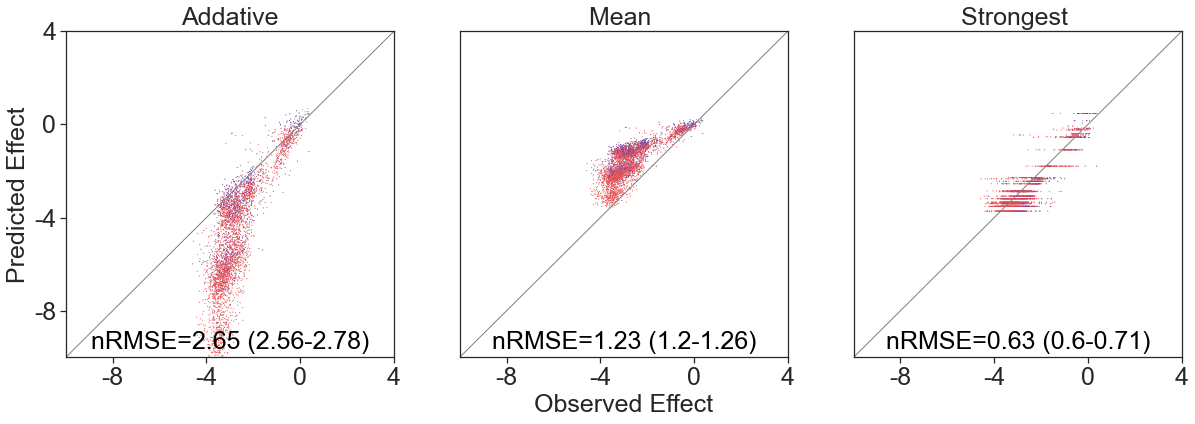

In [68]:
#generate list of models and dictionaries for plot info
models=['additive_single','mean_single', 'strongest_single',]
x_labels_dict={'strongest_single':'Strongest ','additive_single':'Addative','mean_single':'Mean '}

#plot
fig, axes = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(20, 6))
sp_counter=1

#Get normalized RMSE for each model, and  plot model x observed 
for m in models:
    g=plt.subplot(1, 3, sp_counter)
    temp_data=k3_trio_data[[m,'combined_effect', 'qual_monos']].dropna()
    
#     #calculate RMSE and IQR for each model
#     rmse=(mean_squared_error(temp_data[m], temp_data['combined_effect']))**0.5
#     iqr=sp.stats.iqr(temp_data.combined_effect)


    #Get bootstrapped RMSE and IQR for each model
    rmse=round(k3_summ_df[m].median(), 2)
    iqr_l=np.percentile(k3_summ_df[m], 25).round(2)
    iqr_u=np.percentile(k3_summ_df[m], 75).round(2)

    g=sns.scatterplot(y=m, x="combined_effect", data=temp_data, palette=[ 'indigo', '#E21A1C', 'steelblue'],
                      s=1, hue='qual_monos', legend = False)
        
    #add one to one line
    g.add_line(mlines.Line2D([-10,4],[-10,4], 
                             color='grey',linewidth=1, linestyle='-',))
#     #add RMSE value
#     g.text(0.5, 0.01, "nRMSE="+str((rmse/iqr).round(2)), horizontalalignment='center', 
#                verticalalignment='bottom', transform=g.transAxes, 
#                fontdict={'fontsize':25,'color':'Black'},)
    
    #add Bootstraped RMSE value
    g.text(0.5, 0.01, "nRMSE="+str(rmse)+
           " (" + str(iqr_l)+"-" + str(iqr_u)+")", 
           horizontalalignment='center', 
               verticalalignment='bottom', transform=g.transAxes, 
               fontdict={'fontsize':25,'color':'Black'},)


    #add y ticks only to leftmost subplot
    if (sp_counter-1)%3!=0:
        g.set_yticks([])
        g.set_ylabel("")
    else:
        g.set_yticks([-8,-4,0,4])
        g.set_yticklabels([-8,-4,0,4], fontsize = 25)
        g.set_ylabel('Predicted Effect',fontsize = 25)

    g.set_ylim(-10,4)
    g.set_xlim(-10,4)

    g.set_xticks([-8,-4,0,4])
    g.set_xticklabels([-8,-4,0,4], fontsize = 25)
    g.set_title(x_labels_dict[m], fontsize = 25)
    
    #add x title to middle plot only
    if sp_counter==2: 
        g.set_xlabel('Observed Effect', fontsize = 25)
    else:g.set_xlabel('', fontsize = 25)


    sp_counter+=1
fig.savefig('F4_Pa.png',dpi=300, bbox_inches='tight')

### Predicting trio effects from pairs

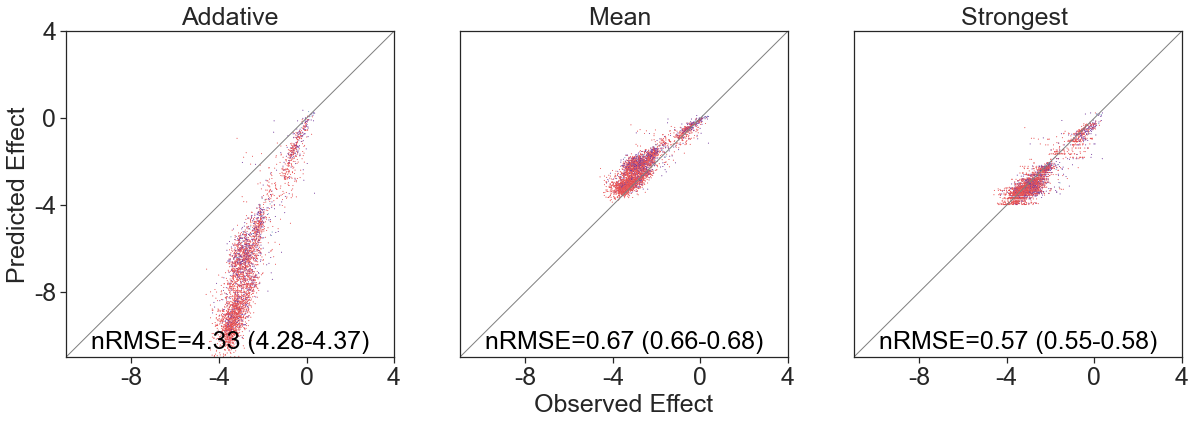

In [69]:
#generate list of models and dictionaries for plot info
models=['additive_pair','mean_pair', 'strongest_pair',]
x_labels_dict={'strongest_pair':'Strongest ','additive_pair':'Addative','mean_pair':'Mean '}

#plot
fig, axes = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(20, 6))
sp_counter=1

#Get normalized RMSE for each model, and  plot model x observed 
for m in models:
    g=plt.subplot(1, 3, sp_counter)
    temp_data=k3_trio_data[[m,'combined_effect', 'qual_monos']].dropna()
    
#     #calculate RMSE and IQR for each model
#     rmse=(mean_squared_error(temp_data[m], temp_data['combined_effect']))**0.5
#     iqr=sp.stats.iqr(temp_data.combined_effect)


    #Get bootstrapped RMSE and IQR for each model
    rmse=round(k3_summ_df[m].median(), 2)
    iqr_l=np.percentile(k3_summ_df[m], 25).round(2)
    iqr_u=np.percentile(k3_summ_df[m], 75).round(2)

    g=sns.scatterplot(y=m, x="combined_effect", data=temp_data, palette=[ 'indigo', '#E21A1C', 'steelblue'],
                      s=1, hue='qual_monos', legend = False)
        
    #add one to one line
    g.add_line(mlines.Line2D([-11,4],[-11,4], 
                             color='grey',linewidth=1, linestyle='-',))
#     #add RMSE value
#     g.text(0.5, 0.01, "nRMSE="+str((rmse/iqr).round(2)), horizontalalignment='center', 
#                verticalalignment='bottom', transform=g.transAxes, 
#                fontdict={'fontsize':25,'color':'Black'},)
    
    #add Bootstraped RMSE value
    g.text(0.5, 0.01, "nRMSE="+str(rmse)+
           " (" + str(iqr_l)+"-" + str(iqr_u)+")", 
           horizontalalignment='center', 
               verticalalignment='bottom', transform=g.transAxes, 
               fontdict={'fontsize':25,'color':'Black'},)

    #add y ticks only to leftmost subplot
    if (sp_counter-1)%3!=0:
        g.set_yticks([])
        g.set_ylabel("")
    else:
        g.set_yticks([-8,-4,0,4])
        g.set_yticklabels([-8,-4,0,4], fontsize = 25)
        g.set_ylabel('Predicted Effect',fontsize = 25)

    g.set_ylim(-11,4)
    g.set_xlim(-11,4)

    g.set_xticks([-8,-4,0,4])
    g.set_xticklabels([-8,-4,0,4], fontsize = 25)
    g.set_title(x_labels_dict[m], fontsize = 25)
    
    #add x title to middle plot only
    if sp_counter==2: 
        g.set_xlabel('Observed Effect', fontsize = 25)
    else:g.set_xlabel('', fontsize = 25)


    sp_counter+=1
fig.savefig('F4_Pb.png',dpi=300, bbox_inches='tight')

## Distribution of effects

In [70]:
singles_for_dist=k3_singles_data.groupby(['sample1','sample2','sample3'],
                        as_index=False).mean()[['sample1', 'combined_effect']].rename(columns={'sample1':'species'})
singles_for_dist['comm_size']='single'

pairs_for_dist=pd.DataFrame(pd.Series(pair_effect_dict)).reset_index().rename(columns={'index':'species',0:'combined_effect'})
pairs_for_dist['comm_size']='pair'


k3_trio_data['species'] =((k3_trio_data[['sample1','sample2','sample3']]).values.tolist())
trios_for_dist=k3_trio_data[['species','combined_effect','comm_size']]
trios_for_dist

dist_df=singles_for_dist.append(pairs_for_dist).append(trios_for_dist)
dist_df

,species,combined_effect,comm_size
0,B_albus,-0.161881,single
1,B_albus,-0.285061,single
2,B_cereus,0.059617,single
3,B_cereus,-0.369852,single
4,B_cereus,-0.262752,single
...,...,...,...
5390,"[P_putida2, R_planticola4, S_rhizophila]",-2.562925,trio
5397,"[P_putida3, P_simiae, R_planticola4]",-3.897220,trio
5398,"[P_putida3, P_simiae, S_rhizophila]",-3.099771,trio
5400,"[P_putida3, R_planticola4, S_rhizophila]",-4.121834,trio


single v.s. pair: Mann-Whitney-Wilcoxon test two-sided, P_val=2.447e-07 U_stat=2.445e+04
pair v.s. trio: Mann-Whitney-Wilcoxon test two-sided, P_val=1.460e-12 U_stat=9.837e+05
single v.s. trio: Mann-Whitney-Wilcoxon test two-sided, P_val=7.250e-16 U_stat=2.364e+05


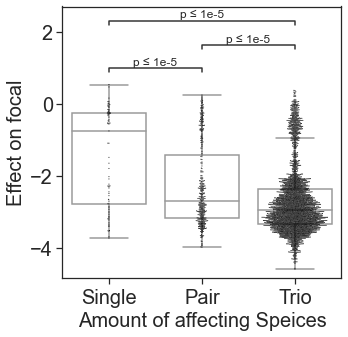

In [71]:
fig, axes = plt.subplots(1,1,figsize=(5,5))

ax=sns.boxplot(data=dist_df, x='comm_size', y='combined_effect',
               color='white', fliersize=0)
ax=sns.swarmplot(data=dist_df, x='comm_size', y='combined_effect',
                 size=1, color='black')

add_stat_annotation(ax, data=dist_df, x="comm_size", y="combined_effect",
                   box_pairs=[("pair", "single"),("pair", "trio"),
                              ("trio", "single")],test='Mann-Whitney', 
                    text_format='simple', verbose=2, comparisons_correction=None)

ax.set_xlabel('Amount of affecting Speices',fontsize=20)
ax.set_ylabel('Effect on focal',fontsize=20)
ax.set_xticklabels(['Single', 'Pair', 'Trio'], fontsize=20)
ax.tick_params(labelsize=20)
# ax.set_ylim(-5,4.5)

fig.savefig('F4_Pc.png',dpi=300, bbox_inches='tight')

### calculate accruacy for each model

In [72]:
warnings.filterwarnings("ignore")

k3_trio_data['mean_accuracy_s']=(k3_trio_data['combined_effect']-
                                 k3_trio_data['mean_single'])

k3_trio_data['mean_accuracy_p']=(k3_trio_data['combined_effect']-
                                 k3_trio_data['mean_pair'])

k3_trio_data['strongest_accuracy_s']=(k3_trio_data['combined_effect']-
                                      k3_trio_data['strongest_single'])

k3_trio_data['strongest_accuracy_p']=(k3_trio_data['combined_effect']-
                                      k3_trio_data['strongest_single'])

k3_trio_data['addtive_accuracy_s']=(k3_trio_data['combined_effect']-
                                    k3_trio_data['additive_single'])

k3_trio_data['addtive_accuracy_p']=(k3_trio_data['combined_effect']-
                                    k3_trio_data['additive_pair'])

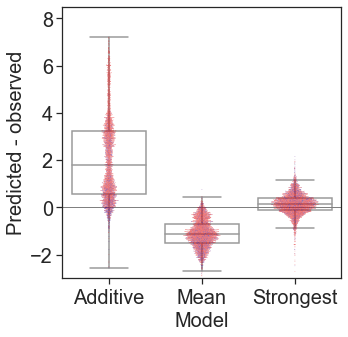

In [73]:
#merge wells with mono droplet to 1:2 or 2:1 wells
k3_pair_data[['sample1','sample2','sample3',]]=k3_pair_data[['sample1','sample2','sample3',]].replace(['Mono1'], np.nan)

k3_pair_data.sample1 = k3_pair_data.sample1.fillna(k3_pair_data.sample2)
k3_pair_data.sample1 = k3_pair_data.sample1.fillna(k3_pair_data.sample3)

k3_pair_data.sample2 = k3_pair_data.sample2.fillna(k3_pair_data.sample1)
k3_pair_data.sample2 = k3_pair_data.sample2.fillna(k3_pair_data.sample3)

k3_pair_data.sample3 = k3_pair_data.sample3.fillna(k3_pair_data.sample1)
k3_pair_data.sample3 = k3_pair_data.sample3.fillna(k3_pair_data.sample2)
fig, axes = plt.subplots(1,1,figsize=(5,5))


melted=(k3_trio_data[['addtive_accuracy_s', 'mean_accuracy_s', 
                    'strongest_accuracy_s','qual_monos']].melt(id_vars='qual_monos',
                                                               value_vars=['addtive_accuracy_s', 'mean_accuracy_s',
                                                                           'strongest_accuracy_s','qual_monos'])
        .replace(x_labels_dict))


ax=sns.boxplot(data=melted, x='variable', y='value',color='white', fliersize=0)
ax=sns.swarmplot(data=melted, x='variable', y='value',size=0.5,
                 hue='qual_monos',palette=[ 'indigo', '#E21A1C', 'steelblue'])
ax.add_line(mlines.Line2D([-4,6],[0,0],color='gray',linewidth=1, linestyle='-',))
ax.get_legend().remove()


ax.set_xlabel('Model',fontsize=20)
ax.set_ylabel('Predicted - observed',fontsize=20)
ax.set_xticklabels(['Additive','Mean', 'Strongest'], fontsize=20)
ax.set_ylim(-3,8.5)
ax.tick_params(labelsize=20)
fig.savefig('F4_Pd.png',dpi=300, bbox_inches='tight')

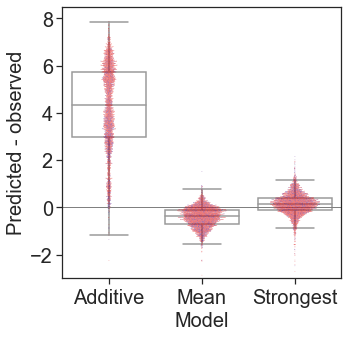

In [74]:
fig, axes = plt.subplots(1,1,figsize=(5,5))

melted=(k3_trio_data[['addtive_accuracy_p', 'mean_accuracy_p', 
                    'strongest_accuracy_p','qual_monos']].melt(id_vars='qual_monos',
                                                               value_vars=['addtive_accuracy_p', 'mean_accuracy_p',
                                                                           'strongest_accuracy_p','qual_monos'])
        .replace(x_labels_dict))


ax=sns.boxplot(data=melted, x='variable', y='value',color='white', fliersize=0)
ax=sns.swarmplot(data=melted, x='variable', y='value',size=0.5,
                 hue='qual_monos',palette=[ 'indigo', '#E21A1C', 'steelblue'])
ax.add_line(mlines.Line2D([-4,6],[0,0],color='gray',linewidth=1, linestyle='-',))
ax.get_legend().remove()


ax.set_xlabel('Model',fontsize=20)
ax.set_ylabel('Predicted - observed',fontsize=20)
ax.set_xticklabels(['Additive','Mean', 'Strongest'], fontsize=20)
ax.set_ylim(-3,8.5)
ax.tick_params(labelsize=20)
fig.savefig('F4_Pe.png',dpi=300, bbox_inches='tight')